# Cào dữ liệu bằng API

Cào bộ dữ liệu laptop chỉ định bằng API trên Web Scraper 

In [431]:
import requests
import time

# Thay thế bằng API Token của bạn
API_TOKEN = "UxLQR7zeuGGlSw9LkonGW7pe3a8Boe2ee5LNmdGoVQ8YQBLbbxLDr9lV18Ed"
BASE_URL = "https://api.webscraper.io/api/v1"

# 1. Lấy danh sách sitemaps
def get_sitemaps():
    url = f"{BASE_URL}/sitemaps?api_token={API_TOKEN}"
    response = requests.get(url)
    if response.status_code == 200:
        sitemaps = response.json().get("data", [])
        print("Danh sách sitemaps:")
        for sitemap in sitemaps:
            print(f"- Tên: {sitemap['name']}, ID: {sitemap['id']}")
        return sitemaps
    else:
        print("Không thể lấy danh sách sitemaps:", response.json())
        return []

# 2. Tạo Scraping Job
def create_scraping_job(sitemap_id):
    url = f"{BASE_URL}/scraping-job?api_token={API_TOKEN}"
    payload = {
        "sitemap_id": sitemap_id,
        "driver": "fast",  # hoặc "fulljs" tùy theo nhu cầu
        "page_load_delay": 2000,
        "request_interval": 2000,
    }
    response = requests.post(url, json=payload)
    if response.status_code == 200 and response.json().get("success"):
        job_id = response.json()["data"]["id"]
        print(f"Scraping job được tạo thành công. Job ID: {job_id}")
        return job_id
    else:
        print("Không thể tạo scraping job:", response.json())
        return None

# 3. Kiểm tra trạng thái Job
def check_job_status(job_id):
    url = f"{BASE_URL}/scraping-job/{job_id}?api_token={API_TOKEN}"
    while True:
        response = requests.get(url)
        if response.status_code == 200:
            status = response.json()["data"]["status"]
            print(f"Trạng thái job: {status}")
            if status == "finished":
                print("Scraping job đã hoàn thành.")
                break
            elif status in ["failed", "stopped"]:
                print("Scraping job thất bại hoặc bị dừng.")
                return False
        else:
            print("Không thể kiểm tra trạng thái job:", response.json())
            return False
        time.sleep(10)  # Đợi 10 giây trước khi kiểm tra lại
    return True

# 4. Tải dữ liệu đã cào
def download_data(job_id, file_name, file_format="json"):
    url = f"{BASE_URL}/scraping-job/{job_id}/{file_format}?api_token={API_TOKEN}"
    response = requests.get(url)
    if response.status_code == 200:
        with open(file_name, "wb") as f:
            f.write(response.content)
        print(f"Dữ liệu đã được tải thành công vào file {file_name}.")
    else:
        print("Không thể tải dữ liệu:", response.json())

# 5. Chạy toàn bộ quy trình
def scrape_sitemap():
    while True:
        sitemaps = get_sitemaps()
        if not sitemaps:
            break
        
        # Nhập ID sitemap muốn cào
        sitemap_id = input("Nhập ID của sitemap muốn cào: ").strip()
        
        # Kiểm tra sitemap_id có hợp lệ không
        selected_sitemap = next((s for s in sitemaps if str(s["id"]) == sitemap_id), None)
        if not selected_sitemap:
            print(f"Bạn đã nhập Sitemap ID: {sitemap_id}")
            print(f"Sitemap ID hợp lệ: {[str(s['id']) for s in sitemaps]}")
            print("Sitemap ID không hợp lệ. Vui lòng thử lại.")
            continue

        
        # Lấy tên sitemap để đặt tên file
        sitemap_name = selected_sitemap["name"]
        file_name = f"{sitemap_name}.csv"  # Đặt file theo tên sitemap
        
        # Tạo job và cào dữ liệu
        job_id = create_scraping_job(sitemap_id)
        if job_id and check_job_status(job_id):
            download_data(job_id, file_name)
        
        # Hỏi người dùng có muốn tiếp tục không
        continue_scraping = input("Bạn có muốn tiếp tục cào (y/n)? (mất phí :(( mỗi lần cào)").strip().lower()
        if continue_scraping != "y":
            print("Kết thúc chương trình.")
            break

if __name__ == "__main__":
    scrape_sitemap()


# Tiền Xử Lý dữ liệu

## Tiền xử lý LaptopAZ và Laptops_anphat

In [432]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder

# 1. Đọc dữ liệu từ file Excel
df_LaptopAZ = pd.read_excel('LaptopAZ.xlsx')
df_LaptopAZ['Link']=df_LaptopAZ['Link san pham-href']
# 2. Xóa các cột không liên quan
columns_to_drop = [
    'web-scraper-order', 'web-scraper-start-url', 'Link trang', 
    'Link trang-href', 'Link san pham', 'Link san pham-href', 'OS_'
]
df_LaptopAZ = df_LaptopAZ.drop(columns=columns_to_drop)

# 3. Xử lý các giá trị thiếu
# Loại bỏ các hàng có giá trị thiếu
df_LaptopAZ = df_LaptopAZ.dropna(how='any')
df_LaptopAZ["Ram"]=df_LaptopAZ["RAM"]
df_LaptopAZ=df_LaptopAZ.drop(columns="RAM")
# Kiểm tra số lượng giá trị thiếu sau khi xóa
print("Số lượng giá trị thiếu sau khi xóa:")
print(df_LaptopAZ.isnull().sum())

df_LaptopAZ

Số lượng giá trị thiếu sau khi xóa:
Name      0
CPU       0
Memory    0
Size      0
GPU       0
Price     0
Link      0
Ram       0
dtype: int64


,Name,CPU,Memory,Size,GPU,Price,Link,Ram
30,[Mới 100%] Laptop Dell XPS 13-9310 (Core i7-11...,11th Generation Intel® Core™ i7-1165G7,SSD 1TB PCIe NVMe Gen3 x4,13.4 Inch UHD+ (3840 x 2400),Intel® Iris® Xe Graphics with shared graphics ...,53.890.000,https://laptopaz.vn/laptop-dell-xps-13-9310-co...,16GB LPDDR4
32,[Mới 100%] Lenovo ThinkPad P16 (Core i5-12600H...,Intel® Core™ i5-12600HX vPro® Processor (E-cor...,512GB M.2 PCIe NMVe SSD,"16.0"" WUXGA (1920 x 1200) IPS, anti-glare, 300...",NVIDIA RTX A1000 4GB (95W),38.000.000,https://laptopaz.vn/lenovo-thinkpad-p16-core-i...,32GB DDR5 Bus 4800MHz
35,[New 100%] Laptop Dell XPS 13-9300 (Core i5-10...,Intel® Core™ i5-1035G1,SSD 256GB,13.4 Inch FHD IPS,intel® UHD Graphics with shared graphics memory,27.890.000,https://laptopaz.vn/moi-100-laptop-dell-xps-13...,8GB DDR4 Bus 2400MHz
37,[Mới 100%] Laptop Dell XPS 13-9310 (Core i5-11...,11th Generation Intel® Core™ i5-1135G7,SSD 256GB PCIe NVMe Gen3 x4,13.4 Inch FHD IPS,Intel® Iris® Xe Graphics with shared graphics ...,33.890.000,https://laptopaz.vn/laptop-dell-xps-13-9310-co...,16GB LPDDR4
38,[Mới 100%] Laptop Dell XPS 13-9310 (Core i7-11...,11th Generation Intel® Core™ i7-1165G7,SSD 512GB PCIe NVMe Gen3 x4,13.4 Inch FHD IPS,Intel® Iris® Xe Graphics with shared graphics ...,43.890.000,https://laptopaz.vn/laptop-dell-xps-13-9310-co...,16GB LPDDR4
...,...,...,...,...,...,...,...,...
275,[New 100%] Dell Inspiron 7445 2-in-1 2024 (Ryz...,AMD Ryzen™ 5 8640HS 6-core/12-thread Processor...,512GB M.2 PCIe NVMe Solid State Drive,14.0-inch 16:10 FHD+ (1920 x 1200) Touch 250ni...,AMD Radeon™ Graphics,14.590.000,https://laptopaz.vn/new-100-dell-inspiron-7445...,"8GB, 1x8GB, DDR5, 5600MHz"
276,[New 100%] HP Envy x360 2-in-1 14-fa0023dx 202...,"Ryzen 7 8840HS ( 8 Cores, 16 Threads, Turbo 3....",1TB PCIe® NVMe™ M.2 SSD,"14"" diagonal, FHD+ (1920 x 1200), multitouch-e...",AMD Radeon™ Graphics,17.890.000,https://laptopaz.vn/new-100-hp-envy-x360-2-in-...,16GB LPDDR5 6400MHz
277,[New 100%] Lenovo Legion Y9000P 2024 (Core i9-...,"14th Generation Intel® Core i9-14900HX, 24C / ...",1TB M.2 PCIe NVMe SSD,"16"" WQXGA (2560×1600) IPS 500nits Anti-glare, ...",NVIDIA GeForce RTX 4060 8GB GDDR6 (140W),37.890.000,https://laptopaz.vn/new-100-lenovo-legion-y900...,32GB DDR5 5600MHz
278,[New 100%] Lenovo LOQ 2024 15IAX9 (Core i5-124...,Intel® Core™ i5-12450HX (2.00GHz up to 4.40GHz...,512GB SSD M.2 2242 PCIe® 4.0x4 NVMe®,15.6inch FHD (1920x1080) IPS 300nits Anti-glar...,NVIDIA® GeForce RTX™ 2050 4GB GDDR6,16.990.000,https://laptopaz.vn/new-100-lenovo-loq-2024-15...,12GB DDR5 4800MHz (up to 32GB)


In [433]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder

# 1. Đọc dữ liệu từ file Excel
df_Laptops_anphat = pd.read_excel('Laptops_anphat.xlsx')
df_Laptops_anphat['Link'] = df_Laptops_anphat['Link_laptop-href']
# 2. Xóa các cột không liên quan
columns_to_drop = [
    'web-scraper-order', 'web-scraper-start-url', 'Link_trang', 'Link_trang-href',
    'Link_laptop', 'Link_laptop-href', 'OS_ver', 'Pin', 'Cân nặng', 'Tính năng',
    'Màu sắc', 'Hãng', 'Giá Khuyến mãi'
]
df_Laptops_anphat = df_Laptops_anphat.drop(columns=columns_to_drop)

# 3. Xử lý các giá trị thiếu
# Loại bỏ các hàng có giá trị thiếu
df_Laptops_anphat = df_Laptops_anphat.dropna(how='any')
# Kiểm tra số lượng giá trị thiếu sau khi xóa
print("Số lượng giá trị thiếu sau khi xóa:")
print(df_Laptops_anphat.isnull().sum())
df_Laptops_anphat

Số lượng giá trị thiếu sau khi xóa:
Tên             0
CPU             0
RAM             0
Ổ Cứng          0
VGA             0
Màn hình        0
giá niêm yết    0
Link            0
dtype: int64


,Tên,CPU,RAM,Ổ Cứng,VGA,Màn hình,giá niêm yết,Link
0,Laptop HP Pavilion X360 14-ek1049TU 80R27PA (I...,"CPU: Intel Core i5-1335U (upto 4.60 GHz, 12MB)",RAM: 16GB DDR4-3200 MHz (onboard),Ổ cứng: 512 GB SSD NVMe PCIe,VGA: Intel Iris Xe,"Màn hình: 14 inch FHD (1920 x 1080), IPS, edge...",24.290.000 đ,https://www.anphatpc.com.vn/laptop-hp-pavilion...
1,Laptop Lenovo Yoga Book 9 13IMU9 83FF001SVN (I...,"CPU: Intel Core Ultra 7 155U (up to 4.80GHz, 2...",RAM: 32GB LPDDR5x-7467MHz,Ổ cứng: 1TB SSD M.2 2242 PCIe® 4.0x4 NVMe®,VGA: Integrated Intel® Graphics,"Màn hình: 13.3 inch 2.8K(2880x1800) OLED, 400n...",66.990.000 đ,https://www.anphatpc.com.vn/laptop-lenovo-yoga...
2,Laptop MSI Katana 15 B13VGK-1211VN (Intel Core...,"CPU: Intel Core i7-13620H (Up to 4.90 GHz, 24MB)",VGA: NVIDIA GeForce RTX 4070 8GB GDDR6 (AI TOP...,"Màn hình: 15.6 inch FHD (1920*1080), 144Hz, IP...",RAM: 16GB (2 x 8GB) DDR5 5600MHz (2 khe),Ổ cứng: 1TB NVMe PCIe SSD Gen4x4,44.990.000 đ,https://www.anphatpc.com.vn/laptop-msi-katana-...
3,Laptop HP ProBook 450 G10 9H1N6PT (Intel Core ...,"CPU: Intel Core i7-1355U (up to 5.0 GHz, 12 MB...",RAM: 8 GB DDR4-3200 MHz RAM (1 x 8 GB),Ổ cứng: 512 GB SSD,VGA: Intel UHD Graphics,"Màn hình: 15.6 inch FHD (1920 x 1080), IPS, na...",25.890.000 đ,https://www.anphatpc.com.vn/laptop-hp-probook-...
4,Laptop Asus Vivobook 14 X1404ZA-NK389W (Intel ...,"CPU: Intel Core i7-1255U (upto 4.70GHz, 12MB)",RAM: 8GB DDR4 on board + 8GB DDR4 SO-DIMM,Ổ cứng: 512GB SSD M.2 NVMe,VGA: Intel Iris Xe Graphics,Màn hình: 14 inch FHD (1920 x 1080) 16:9 aspec...,17.990.000 đ,https://www.anphatpc.com.vn/laptop-asus-vivobo...
...,...,...,...,...,...,...,...,...
139,Laptop Acer Predator Helios Neo PHN16-72-78DQ_...,"CPU: Intel Core i7-14650HX (upto 5.20 GHz, 16 ...",VGA: NVIDIA® GeForce RTX 4060 8 GB (AI TOPS: 233),Màn hình: 16 inch WQXGA (2560 x 1600) 240Hz DC...,"RAM: 1*16GB DDR5 (2 khe, tối đa 32GB, cắm sẵn ...",Ổ cứng: 1TB PCIe NVMe SED SSD (nâng cấp tối đ...,46.990.000 đ,https://www.anphatpc.com.vn/laptop-acer-predat...
140,Laptop ASUS TUF Gaming A14 FA401WV-RG062WS (AM...,"CPU: AMD Ryzen AI 9 HX 370 (36MB Cache, up to ...","RAM: 8GB*2 LPDDR5X 7500 on board (2 khe, tối đ...",Ổ cứng: 1TB PCIe® 4.0 NVMe™ M.2 SSD,VGA: NVIDIA® GeForce RTX™ 4060 8GB GDDR6 (AI T...,"Màn hình: 14 inch 2.5K (2560 x 1600, WQXGA) 16...",44.990.000 đ,https://www.anphatpc.com.vn/laptop-asus-tuf-ga...
141,Laptop Asus ROG Strix G16 G614JI-N4125W (Intel...,CPU: Intel Core i7-13650HX Processor (upto 4.9...,VGA: NVIDIA GeForce RTX 4070 8GB GDDR6,"Màn hình: 16 inch QHD+ 16:10 (2560 x 1600, WQX...",RAM: 16GB DDR5-4800 SO-DIMM,Ổ cứng: 512GB PCIe® 4.0 NVMe™ M.2 SSD,54.990.000 đ,https://www.anphatpc.com.vn/laptop-asus-rog-st...
142,Laptop HP 14s-ep0110TU 8C5K9PA (Intel Core i7-...,"CPU: Intel Core i7-1355U (12MB, up to 5.00GHz)",RAM: 16GB DDR4-3200 MHz RAM (2 x 8GB),Ổ cứng: 512 GB PCIe® NVMe™ M.2 SSD,VGA: Intel Intel Iris Xe,"Màn hình: 14 inch FHD (1920 x 1080), micro-edg...",21.990.000 đ,https://www.anphatpc.com.vn/laptop-hp-14s-ep01...


In [434]:
import pandas as pd
import random

def preprocess_file(df, column_mapping):

    # Đổi tên các cột theo ánh xạ
    df = df.rename(columns=column_mapping)

    # Chọn các cột cần thiết (nếu cột không tồn tại, thêm cột đó với giá trị mặc định là None)
    required_columns = ['Name', 'Price', 'CPU', 'Ram', 'Memory', 'Size', 'GPU','Link']
    for col in required_columns:
        if col not in df.columns:
            df[col] = None

    # Lưu file kết quả
    df = df[required_columns]  # Đảm bảo đúng thứ tự các cột
    return df

# Ánh xạ tên cột hiện tại về tên chuẩn
column_mapping_anphat = {
    'Tên': 'Name',
    'giá niêm yết': 'Price',
    'CPU': 'CPU',
    'RAM': 'Ram',
    'Ổ Cứng': 'Memory',
    'Màn hình': 'Size',
    'VGA': 'GPU'
}
df_Laptops_anphat=preprocess_file(df_Laptops_anphat,  column_mapping_anphat)
df_Laptops_anphat

,Name,Price,CPU,Ram,Memory,Size,GPU,Link
0,Laptop HP Pavilion X360 14-ek1049TU 80R27PA (I...,24.290.000 đ,"CPU: Intel Core i5-1335U (upto 4.60 GHz, 12MB)",RAM: 16GB DDR4-3200 MHz (onboard),Ổ cứng: 512 GB SSD NVMe PCIe,"Màn hình: 14 inch FHD (1920 x 1080), IPS, edge...",VGA: Intel Iris Xe,https://www.anphatpc.com.vn/laptop-hp-pavilion...
1,Laptop Lenovo Yoga Book 9 13IMU9 83FF001SVN (I...,66.990.000 đ,"CPU: Intel Core Ultra 7 155U (up to 4.80GHz, 2...",RAM: 32GB LPDDR5x-7467MHz,Ổ cứng: 1TB SSD M.2 2242 PCIe® 4.0x4 NVMe®,"Màn hình: 13.3 inch 2.8K(2880x1800) OLED, 400n...",VGA: Integrated Intel® Graphics,https://www.anphatpc.com.vn/laptop-lenovo-yoga...
2,Laptop MSI Katana 15 B13VGK-1211VN (Intel Core...,44.990.000 đ,"CPU: Intel Core i7-13620H (Up to 4.90 GHz, 24MB)",VGA: NVIDIA GeForce RTX 4070 8GB GDDR6 (AI TOP...,"Màn hình: 15.6 inch FHD (1920*1080), 144Hz, IP...",Ổ cứng: 1TB NVMe PCIe SSD Gen4x4,RAM: 16GB (2 x 8GB) DDR5 5600MHz (2 khe),https://www.anphatpc.com.vn/laptop-msi-katana-...
3,Laptop HP ProBook 450 G10 9H1N6PT (Intel Core ...,25.890.000 đ,"CPU: Intel Core i7-1355U (up to 5.0 GHz, 12 MB...",RAM: 8 GB DDR4-3200 MHz RAM (1 x 8 GB),Ổ cứng: 512 GB SSD,"Màn hình: 15.6 inch FHD (1920 x 1080), IPS, na...",VGA: Intel UHD Graphics,https://www.anphatpc.com.vn/laptop-hp-probook-...
4,Laptop Asus Vivobook 14 X1404ZA-NK389W (Intel ...,17.990.000 đ,"CPU: Intel Core i7-1255U (upto 4.70GHz, 12MB)",RAM: 8GB DDR4 on board + 8GB DDR4 SO-DIMM,Ổ cứng: 512GB SSD M.2 NVMe,Màn hình: 14 inch FHD (1920 x 1080) 16:9 aspec...,VGA: Intel Iris Xe Graphics,https://www.anphatpc.com.vn/laptop-asus-vivobo...
...,...,...,...,...,...,...,...,...
139,Laptop Acer Predator Helios Neo PHN16-72-78DQ_...,46.990.000 đ,"CPU: Intel Core i7-14650HX (upto 5.20 GHz, 16 ...",VGA: NVIDIA® GeForce RTX 4060 8 GB (AI TOPS: 233),Màn hình: 16 inch WQXGA (2560 x 1600) 240Hz DC...,Ổ cứng: 1TB PCIe NVMe SED SSD (nâng cấp tối đ...,"RAM: 1*16GB DDR5 (2 khe, tối đa 32GB, cắm sẵn ...",https://www.anphatpc.com.vn/laptop-acer-predat...
140,Laptop ASUS TUF Gaming A14 FA401WV-RG062WS (AM...,44.990.000 đ,"CPU: AMD Ryzen AI 9 HX 370 (36MB Cache, up to ...","RAM: 8GB*2 LPDDR5X 7500 on board (2 khe, tối đ...",Ổ cứng: 1TB PCIe® 4.0 NVMe™ M.2 SSD,"Màn hình: 14 inch 2.5K (2560 x 1600, WQXGA) 16...",VGA: NVIDIA® GeForce RTX™ 4060 8GB GDDR6 (AI T...,https://www.anphatpc.com.vn/laptop-asus-tuf-ga...
141,Laptop Asus ROG Strix G16 G614JI-N4125W (Intel...,54.990.000 đ,CPU: Intel Core i7-13650HX Processor (upto 4.9...,VGA: NVIDIA GeForce RTX 4070 8GB GDDR6,"Màn hình: 16 inch QHD+ 16:10 (2560 x 1600, WQX...",Ổ cứng: 512GB PCIe® 4.0 NVMe™ M.2 SSD,RAM: 16GB DDR5-4800 SO-DIMM,https://www.anphatpc.com.vn/laptop-asus-rog-st...
142,Laptop HP 14s-ep0110TU 8C5K9PA (Intel Core i7-...,21.990.000 đ,"CPU: Intel Core i7-1355U (12MB, up to 5.00GHz)",RAM: 16GB DDR4-3200 MHz RAM (2 x 8GB),Ổ cứng: 512 GB PCIe® NVMe™ M.2 SSD,"Màn hình: 14 inch FHD (1920 x 1080), micro-edg...",VGA: Intel Intel Iris Xe,https://www.anphatpc.com.vn/laptop-hp-14s-ep01...


In [435]:
df_LaptopAZ_Laptop_anphat = pd.concat([df_LaptopAZ,df_Laptops_anphat], ignore_index=True)
df_LaptopAZ_Laptop_anphat

,Name,CPU,Memory,Size,GPU,Price,Link,Ram
0,[Mới 100%] Laptop Dell XPS 13-9310 (Core i7-11...,11th Generation Intel® Core™ i7-1165G7,SSD 1TB PCIe NVMe Gen3 x4,13.4 Inch UHD+ (3840 x 2400),Intel® Iris® Xe Graphics with shared graphics ...,53.890.000,https://laptopaz.vn/laptop-dell-xps-13-9310-co...,16GB LPDDR4
1,[Mới 100%] Lenovo ThinkPad P16 (Core i5-12600H...,Intel® Core™ i5-12600HX vPro® Processor (E-cor...,512GB M.2 PCIe NMVe SSD,"16.0"" WUXGA (1920 x 1200) IPS, anti-glare, 300...",NVIDIA RTX A1000 4GB (95W),38.000.000,https://laptopaz.vn/lenovo-thinkpad-p16-core-i...,32GB DDR5 Bus 4800MHz
2,[New 100%] Laptop Dell XPS 13-9300 (Core i5-10...,Intel® Core™ i5-1035G1,SSD 256GB,13.4 Inch FHD IPS,intel® UHD Graphics with shared graphics memory,27.890.000,https://laptopaz.vn/moi-100-laptop-dell-xps-13...,8GB DDR4 Bus 2400MHz
3,[Mới 100%] Laptop Dell XPS 13-9310 (Core i5-11...,11th Generation Intel® Core™ i5-1135G7,SSD 256GB PCIe NVMe Gen3 x4,13.4 Inch FHD IPS,Intel® Iris® Xe Graphics with shared graphics ...,33.890.000,https://laptopaz.vn/laptop-dell-xps-13-9310-co...,16GB LPDDR4
4,[Mới 100%] Laptop Dell XPS 13-9310 (Core i7-11...,11th Generation Intel® Core™ i7-1165G7,SSD 512GB PCIe NVMe Gen3 x4,13.4 Inch FHD IPS,Intel® Iris® Xe Graphics with shared graphics ...,43.890.000,https://laptopaz.vn/laptop-dell-xps-13-9310-co...,16GB LPDDR4
...,...,...,...,...,...,...,...,...
341,Laptop Acer Predator Helios Neo PHN16-72-78DQ_...,"CPU: Intel Core i7-14650HX (upto 5.20 GHz, 16 ...",Màn hình: 16 inch WQXGA (2560 x 1600) 240Hz DC...,Ổ cứng: 1TB PCIe NVMe SED SSD (nâng cấp tối đ...,"RAM: 1*16GB DDR5 (2 khe, tối đa 32GB, cắm sẵn ...",46.990.000 đ,https://www.anphatpc.com.vn/laptop-acer-predat...,VGA: NVIDIA® GeForce RTX 4060 8 GB (AI TOPS: 233)
342,Laptop ASUS TUF Gaming A14 FA401WV-RG062WS (AM...,"CPU: AMD Ryzen AI 9 HX 370 (36MB Cache, up to ...",Ổ cứng: 1TB PCIe® 4.0 NVMe™ M.2 SSD,"Màn hình: 14 inch 2.5K (2560 x 1600, WQXGA) 16...",VGA: NVIDIA® GeForce RTX™ 4060 8GB GDDR6 (AI T...,44.990.000 đ,https://www.anphatpc.com.vn/laptop-asus-tuf-ga...,"RAM: 8GB*2 LPDDR5X 7500 on board (2 khe, tối đ..."
343,Laptop Asus ROG Strix G16 G614JI-N4125W (Intel...,CPU: Intel Core i7-13650HX Processor (upto 4.9...,"Màn hình: 16 inch QHD+ 16:10 (2560 x 1600, WQX...",Ổ cứng: 512GB PCIe® 4.0 NVMe™ M.2 SSD,RAM: 16GB DDR5-4800 SO-DIMM,54.990.000 đ,https://www.anphatpc.com.vn/laptop-asus-rog-st...,VGA: NVIDIA GeForce RTX 4070 8GB GDDR6
344,Laptop HP 14s-ep0110TU 8C5K9PA (Intel Core i7-...,"CPU: Intel Core i7-1355U (12MB, up to 5.00GHz)",Ổ cứng: 512 GB PCIe® NVMe™ M.2 SSD,"Màn hình: 14 inch FHD (1920 x 1080), micro-edg...",VGA: Intel Intel Iris Xe,21.990.000 đ,https://www.anphatpc.com.vn/laptop-hp-14s-ep01...,RAM: 16GB DDR4-3200 MHz RAM (2 x 8GB)


In [436]:

def fix_columns(row):
    if "Màn hình: " in row['Memory']:
        return {
            'Name': row['Name'],
            'CPU': row['CPU'],
            'Memory': row['Size'],
            'Size': row['Memory'],
            'GPU': row['Ram'],
            'Ram': row['GPU'],
            'Price': row['Price']
        }
    return row



# Áp dụng sửa dữ liệu
df_LaptopAZ_Laptop_anphat = df_LaptopAZ_Laptop_anphat.apply(fix_columns, axis=1, result_type='expand')
df_LaptopAZ_Laptop_anphat

,CPU,GPU,Link,Memory,Name,Price,Ram,Size
0,11th Generation Intel® Core™ i7-1165G7,Intel® Iris® Xe Graphics with shared graphics ...,https://laptopaz.vn/laptop-dell-xps-13-9310-co...,SSD 1TB PCIe NVMe Gen3 x4,[Mới 100%] Laptop Dell XPS 13-9310 (Core i7-11...,53.890.000,16GB LPDDR4,13.4 Inch UHD+ (3840 x 2400)
1,Intel® Core™ i5-12600HX vPro® Processor (E-cor...,NVIDIA RTX A1000 4GB (95W),https://laptopaz.vn/lenovo-thinkpad-p16-core-i...,512GB M.2 PCIe NMVe SSD,[Mới 100%] Lenovo ThinkPad P16 (Core i5-12600H...,38.000.000,32GB DDR5 Bus 4800MHz,"16.0"" WUXGA (1920 x 1200) IPS, anti-glare, 300..."
2,Intel® Core™ i5-1035G1,intel® UHD Graphics with shared graphics memory,https://laptopaz.vn/moi-100-laptop-dell-xps-13...,SSD 256GB,[New 100%] Laptop Dell XPS 13-9300 (Core i5-10...,27.890.000,8GB DDR4 Bus 2400MHz,13.4 Inch FHD IPS
3,11th Generation Intel® Core™ i5-1135G7,Intel® Iris® Xe Graphics with shared graphics ...,https://laptopaz.vn/laptop-dell-xps-13-9310-co...,SSD 256GB PCIe NVMe Gen3 x4,[Mới 100%] Laptop Dell XPS 13-9310 (Core i5-11...,33.890.000,16GB LPDDR4,13.4 Inch FHD IPS
4,11th Generation Intel® Core™ i7-1165G7,Intel® Iris® Xe Graphics with shared graphics ...,https://laptopaz.vn/laptop-dell-xps-13-9310-co...,SSD 512GB PCIe NVMe Gen3 x4,[Mới 100%] Laptop Dell XPS 13-9310 (Core i7-11...,43.890.000,16GB LPDDR4,13.4 Inch FHD IPS
...,...,...,...,...,...,...,...,...
341,"CPU: Intel Core i7-14650HX (upto 5.20 GHz, 16 ...",VGA: NVIDIA® GeForce RTX 4060 8 GB (AI TOPS: 233),NaN,Ổ cứng: 1TB PCIe NVMe SED SSD (nâng cấp tối đ...,Laptop Acer Predator Helios Neo PHN16-72-78DQ_...,46.990.000 đ,"RAM: 1*16GB DDR5 (2 khe, tối đa 32GB, cắm sẵn ...",Màn hình: 16 inch WQXGA (2560 x 1600) 240Hz DC...
342,"CPU: AMD Ryzen AI 9 HX 370 (36MB Cache, up to ...",VGA: NVIDIA® GeForce RTX™ 4060 8GB GDDR6 (AI T...,https://www.anphatpc.com.vn/laptop-asus-tuf-ga...,Ổ cứng: 1TB PCIe® 4.0 NVMe™ M.2 SSD,Laptop ASUS TUF Gaming A14 FA401WV-RG062WS (AM...,44.990.000 đ,"RAM: 8GB*2 LPDDR5X 7500 on board (2 khe, tối đ...","Màn hình: 14 inch 2.5K (2560 x 1600, WQXGA) 16..."
343,CPU: Intel Core i7-13650HX Processor (upto 4.9...,VGA: NVIDIA GeForce RTX 4070 8GB GDDR6,NaN,Ổ cứng: 512GB PCIe® 4.0 NVMe™ M.2 SSD,Laptop Asus ROG Strix G16 G614JI-N4125W (Intel...,54.990.000 đ,RAM: 16GB DDR5-4800 SO-DIMM,"Màn hình: 16 inch QHD+ 16:10 (2560 x 1600, WQX..."
344,"CPU: Intel Core i7-1355U (12MB, up to 5.00GHz)",VGA: Intel Intel Iris Xe,https://www.anphatpc.com.vn/laptop-hp-14s-ep01...,Ổ cứng: 512 GB PCIe® NVMe™ M.2 SSD,Laptop HP 14s-ep0110TU 8C5K9PA (Intel Core i7-...,21.990.000 đ,RAM: 16GB DDR4-3200 MHz RAM (2 x 8GB),"Màn hình: 14 inch FHD (1920 x 1080), micro-edg..."


In [437]:
# Xử lý cột CPU để lấy phần chứa "Core" hoặc "Ryzen"
df_LaptopAZ_Laptop_anphat['CPU'] = df_LaptopAZ_Laptop_anphat['CPU'].str.extract(r'(Core.*|Ryzen.*)')
# Xử lý cột Memory để chỉ lấy kích thước (ví dụ: 1TB hoặc 256GB)
df_LaptopAZ_Laptop_anphat['Memory'] = df_LaptopAZ_Laptop_anphat['Memory'].str.extract(r'(\d+[TBGB]+|\d+[ TBGB]+)')

# Xử lý cột Ram để chỉ lấy kích thước RAM (ví dụ: 16GB, 32GB)
df_LaptopAZ_Laptop_anphat['Ram'] = df_LaptopAZ_Laptop_anphat['Ram'].str.extract(r'(\d+GB|\d+ GB)')

# Xử lý cột Size để chỉ lấy kích thước màn hình (ví dụ: 13.4, 16.0)
df_LaptopAZ_Laptop_anphat['Size'] = df_LaptopAZ_Laptop_anphat['Size'].str.extract(r'(\d+\.?\d*)').astype(float)
df_LaptopAZ_Laptop_anphat['Name'] = df_LaptopAZ_Laptop_anphat['Name'].str.replace(r'\[Mới 100%\]|\[New 100%\]', '', regex=True)
df_LaptopAZ_Laptop_anphat['GPU'] = df_LaptopAZ_Laptop_anphat['GPU'].str.replace(r'^VGA:\s*', '', regex=True)
df_LaptopAZ_Laptop_anphat["Price"] = df_LaptopAZ_Laptop_anphat["Price"].str.replace("đ", "").str.replace('.', '', regex=False)  # Bỏ "₫" trong cột Price
df_LaptopAZ_Laptop_anphat["Ram"] = df_LaptopAZ_Laptop_anphat["Ram"].str.replace("GB", "")

# Hiển thị kết quả
df_LaptopAZ_Laptop_anphat


,CPU,GPU,Link,Memory,Name,Price,Ram,Size
0,Core™ i7-1165G7,Intel® Iris® Xe Graphics with shared graphics ...,https://laptopaz.vn/laptop-dell-xps-13-9310-co...,1TB,"Laptop Dell XPS 13-9310 (Core i7-1165G7, 16GB...",53890000,16,13.4
1,Core™ i5-12600HX vPro® Processor (E-cores up t...,NVIDIA RTX A1000 4GB (95W),https://laptopaz.vn/lenovo-thinkpad-p16-core-i...,512GB,"Lenovo ThinkPad P16 (Core i5-12600HX, 16GB, ...",38000000,32,16.0
2,Core™ i5-1035G1,intel® UHD Graphics with shared graphics memory,https://laptopaz.vn/moi-100-laptop-dell-xps-13...,256GB,"Laptop Dell XPS 13-9300 (Core i5-1035G1, 8GB,...",27890000,8,13.4
3,Core™ i5-1135G7,Intel® Iris® Xe Graphics with shared graphics ...,https://laptopaz.vn/laptop-dell-xps-13-9310-co...,256GB,"Laptop Dell XPS 13-9310 (Core i5-1135G7, 16GB...",33890000,16,13.4
4,Core™ i7-1165G7,Intel® Iris® Xe Graphics with shared graphics ...,https://laptopaz.vn/laptop-dell-xps-13-9310-co...,512GB,"Laptop Dell XPS 13-9310 (Core i7-1165G7, 16GB...",43890000,16,13.4
...,...,...,...,...,...,...,...,...
341,"Core i7-14650HX (upto 5.20 GHz, 16 nhân 24 luồ...",NVIDIA® GeForce RTX 4060 8 GB (AI TOPS: 233),NaN,1TB,Laptop Acer Predator Helios Neo PHN16-72-78DQ_...,46990000,16,16.0
342,"Ryzen AI 9 HX 370 (36MB Cache, up to 5.1GHz, 1...",NVIDIA® GeForce RTX™ 4060 8GB GDDR6 (AI TOPS: ...,https://www.anphatpc.com.vn/laptop-asus-tuf-ga...,1TB,Laptop ASUS TUF Gaming A14 FA401WV-RG062WS (AM...,44990000,8,14.0
343,"Core i7-13650HX Processor (upto 4.90 GHz, 24MB)",NVIDIA GeForce RTX 4070 8GB GDDR6,NaN,512GB,Laptop Asus ROG Strix G16 G614JI-N4125W (Intel...,54990000,16,16.0
344,"Core i7-1355U (12MB, up to 5.00GHz)",Intel Intel Iris Xe,https://www.anphatpc.com.vn/laptop-hp-14s-ep01...,512 GB,Laptop HP 14s-ep0110TU 8C5K9PA (Intel Core i7-...,21990000,16,14.0


In [438]:
df_LaptopAZ_Laptop_anphat.isnull().sum()

CPU        8
GPU        0
Link      39
Memory     2
Name       0
Price      0
Ram        9
Size       2
dtype: int64

In [439]:
df_LaptopAZ_Laptop_anphat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 346 entries, 0 to 345
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   CPU     338 non-null    object 
 1   GPU     346 non-null    object 
 2   Link    307 non-null    object 
 3   Memory  344 non-null    object 
 4   Name    346 non-null    object 
 5   Price   346 non-null    object 
 6   Ram     337 non-null    object 
 7   Size    344 non-null    float64
dtypes: float64(1), object(7)
memory usage: 21.8+ KB


In [440]:
memory_data = df_LaptopAZ_Laptop_anphat['Memory'].str.extract(r'(\d+)\s*(GB|TB)', expand=True)
memory_data.dropna(inplace=True)
df_LaptopAZ_Laptop_anphat['Memory'] = memory_data[0].astype(int) * memory_data[1].map({'GB': 1, 'TB': 1024})
# Loại bỏ nội dung trong ngoặc đơn và các dấu cách dư thừa
df_LaptopAZ_Laptop_anphat['CPU'] = df_LaptopAZ_Laptop_anphat['CPU'].str.replace(r'\s*\(.*?\)', '', regex=True).str.strip()

In [441]:
df_LaptopAZ_Laptop_anphat

,CPU,GPU,Link,Memory,Name,Price,Ram,Size
0,Core™ i7-1165G7,Intel® Iris® Xe Graphics with shared graphics ...,https://laptopaz.vn/laptop-dell-xps-13-9310-co...,1024.0,"Laptop Dell XPS 13-9310 (Core i7-1165G7, 16GB...",53890000,16,13.4
1,Core™ i5-12600HX vPro® Processor,NVIDIA RTX A1000 4GB (95W),https://laptopaz.vn/lenovo-thinkpad-p16-core-i...,512.0,"Lenovo ThinkPad P16 (Core i5-12600HX, 16GB, ...",38000000,32,16.0
2,Core™ i5-1035G1,intel® UHD Graphics with shared graphics memory,https://laptopaz.vn/moi-100-laptop-dell-xps-13...,256.0,"Laptop Dell XPS 13-9300 (Core i5-1035G1, 8GB,...",27890000,8,13.4
3,Core™ i5-1135G7,Intel® Iris® Xe Graphics with shared graphics ...,https://laptopaz.vn/laptop-dell-xps-13-9310-co...,256.0,"Laptop Dell XPS 13-9310 (Core i5-1135G7, 16GB...",33890000,16,13.4
4,Core™ i7-1165G7,Intel® Iris® Xe Graphics with shared graphics ...,https://laptopaz.vn/laptop-dell-xps-13-9310-co...,512.0,"Laptop Dell XPS 13-9310 (Core i7-1165G7, 16GB...",43890000,16,13.4
...,...,...,...,...,...,...,...,...
341,Core i7-14650HX,NVIDIA® GeForce RTX 4060 8 GB (AI TOPS: 233),NaN,1024.0,Laptop Acer Predator Helios Neo PHN16-72-78DQ_...,46990000,16,16.0
342,Ryzen AI 9 HX 370; AMD Ryzen™ AI up to 81 TOPs,NVIDIA® GeForce RTX™ 4060 8GB GDDR6 (AI TOPS: ...,https://www.anphatpc.com.vn/laptop-asus-tuf-ga...,1024.0,Laptop ASUS TUF Gaming A14 FA401WV-RG062WS (AM...,44990000,8,14.0
343,Core i7-13650HX Processor,NVIDIA GeForce RTX 4070 8GB GDDR6,NaN,512.0,Laptop Asus ROG Strix G16 G614JI-N4125W (Intel...,54990000,16,16.0
344,Core i7-1355U,Intel Intel Iris Xe,https://www.anphatpc.com.vn/laptop-hp-14s-ep01...,512.0,Laptop HP 14s-ep0110TU 8C5K9PA (Intel Core i7-...,21990000,16,14.0


## Tiền xử lý laptop88 và Laptop_ankhang

In [442]:
import numpy as np
import pandas as pd
import seaborn as sns
import re
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split

In [443]:
df_laptop88 = pd.read_excel('laptop88.xlsx', engine='openpyxl')
df_Laptop_ankhang = pd.read_excel('Laptop_ankhang.xlsx', engine='openpyxl')
df_laptop88['Link']=df_laptop88['link_sp-href']
df_Laptop_ankhang['Link']=df_Laptop_ankhang['link_sanpham-href']
df_laptop88

,web-scraper-order,web-scraper-start-url,link_trang,link_trang-href,link_sp,link_sp-href,Name,CPU,Ram,Memory,GPU,Size,Price,Link
0,1733845796-1,https://laptop88.vn/laptop-moi.html,7,https://laptop88.vn/laptop-moi.html?page=7,[New 100%] Lenovo Legion Y7000P IRX9 83JJ0000C...,https://laptop88.vn/new-100-lenovo-legion-y700...,[New 100%] Lenovo Legion Y7000P IRX9 83JJ0000C...,Intel Core i7 -13650HX,24GB DDR5,SSD 512GB NVMe,NVIDIA GeForce RTX 4060 8GB GDDR6,15.6 inch Full HD 144Hz 100% sRGB,29.990.000đ,https://laptop88.vn/new-100-lenovo-legion-y700...
1,1733845799-2,https://laptop88.vn/laptop-moi.html,7,https://laptop88.vn/laptop-moi.html?page=7,[New 100%] Laptop Lenovo ThinkBook 16 Gen 6 21...,https://laptop88.vn/new-100-laptop-lenovo-thin...,[New 100%] Laptop Lenovo ThinkBook 16 Gen 6 21...,AMD Ryzen™ 7 7730U,32GB DDR4,SSD 1TB NVMe,AMD Radeon Graphics,16 inch 2K 100% sRGB,21.590.000đ,https://laptop88.vn/new-100-laptop-lenovo-thin...
2,1733845801-3,https://laptop88.vn/laptop-moi.html,7,https://laptop88.vn/laptop-moi.html?page=7,[New 100%] Laptop Lenovo ThinkBook 14 Gen 6 21...,https://laptop88.vn/new-100-laptop-lenovo-thin...,[New 100%] Laptop Lenovo ThinkBook 14 Gen 6 21...,Intel® Core i7-1355U,16GB DDR5,SSD 512GB NVMe,Intel Iris Xe Graphics,14 inch Full HD+,21.290.000đ,https://laptop88.vn/new-100-laptop-lenovo-thin...
3,1733845804-4,https://laptop88.vn/laptop-moi.html,7,https://laptop88.vn/laptop-moi.html?page=7,[New 100%] Laptop Lenovo ThinkBook 14 Gen 6 21...,https://laptop88.vn/new-100-laptop-lenovo-thin...,[New 100%] Laptop Lenovo ThinkBook 14 Gen 6 21...,AMD Ryzen 5-7530U,16GB DDR4,SSD 512GB NVMe,Integrated AMD Radeon™ Graphics,14 inch Full HD+,15.790.000đ,https://laptop88.vn/new-100-laptop-lenovo-thin...
4,1733845809-5,https://laptop88.vn/laptop-moi.html,7,https://laptop88.vn/laptop-moi.html?page=7,[New Outlet] Laptop Lenovo LOQ 15IAX9 83GS001R...,https://laptop88.vn/new-outlet-laptop-lenovo-l...,[New Outlet] Laptop Lenovo LOQ 15IAX9 83GS001R...,Intel Core i5-12450HX,12GB DDR5,SSD 512GB,RTX 3050 6GB GDDR6,15.6 inch Full HD 100% sRGB 144Hz,19.690.000đ,https://laptop88.vn/new-outlet-laptop-lenovo-l...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,1733846736-140,https://laptop88.vn/laptop-moi.html,2,https://laptop88.vn/laptop-moi.html?page=2,[New 100%] Laptop HP Envy x360 2 in 1 14-fa001...,https://laptop88.vn/new-100-laptop-hp-envy-x36...,[New 100%] Laptop HP Envy x360 2 in 1 14-fa001...,AMD R5-8640HS,16GB LPDDR5,SSD 512GB NVMe,AMD Radeon Graphics,14 inch Full HD+ Touch,15.590.000đ,https://laptop88.vn/new-100-laptop-hp-envy-x36...
140,1733846746-141,https://laptop88.vn/laptop-moi.html,2,https://laptop88.vn/laptop-moi.html?page=2,[New 100%] Dell Inspiron 15 3530 R4508S / R160...,https://laptop88.vn/new-100-dell-inspiron-15-3...,[New 100%] Dell Inspiron 15 3530 R4508S / R160...,Intel Core i5-1334U,8GB DDR4 (R4508S),SSD 512GB NVMe,Intel Graphics,15.6 Inch Full HD,13.590.000đ,https://laptop88.vn/new-100-dell-inspiron-15-3...
141,1733846756-142,https://laptop88.vn/laptop-moi.html,2,https://laptop88.vn/laptop-moi.html?page=2,[New 100%] HP Envy x360 2 in 1 14-es1023dx 9R8...,https://laptop88.vn/new-100-hp-envy-x360-2-in-...,[New 100%] HP Envy x360 2 in 1 14-es1023dx 9R8...,Intel Core 7 -150U,16GB DDR4,SSD 512GB NVMe,Intel Iris Xe Graphics,14 inch Full HD (1920 x 1080) Touch,17.990.000đ,https://laptop88.vn/new-100-hp-envy-x360-2-in-...
142,1733846782-143,https://laptop88.vn/laptop-moi.html,2,https://laptop88.vn/laptop-moi.html?page=2,[New Outlet] Laptop Lenovo Flex 7 14IAU8 82Y20...,https://laptop88.vn/new-outlet-laptop-lenovo-f...,[New Outlet] Laptop Lenovo Flex 7 14IAU8 82Y20...,Intel® Core™ i7-1355U,16GB LPDDR4,SSD 1TB NVMe,Intel® Iris® Xe Graphics,"14 inch 2.2K, 100% sRGB",15.690.000Đ,https://laptop88.vn/new-outlet-laptop-lenovo-f...


In [444]:
df_Laptop_ankhang

,web-scraper-order,web-scraper-start-url,link_trang,link_trang-href,link_sanpham,link_sanpham-href,Name,CPU,Ram,Memory,OS_,Size,GPU,Price,Link
0,1733849057-1,https://www.ankhang.vn/laptop.html?gad_source=...,7,https://www.ankhang.vn/laptop.html?gad_source=...,Laptop Gigabyte G5 KF-E3VN333SH,https://www.ankhang.vn/laptop-gigabyte-g5-kf-e...,Laptop Gigabyte G5 KF-E3VN333SH,"CPU Intel Core i5-12500H (18MB, up to 4.50GHz)",RAM 8GB DDR4 3200MHz,SSD 512GB M.2 NVMe PCIe Gen4,Windows 11 Home SL,Display 15.6Inch FHD 144Hz 45%NTSC,VGA NVIDIA GeForce RTX 4060 8GB GDDR6,NaN,https://www.ankhang.vn/laptop-gigabyte-g5-kf-e...
1,1733849075-2,https://www.ankhang.vn/laptop.html?gad_source=...,7,https://www.ankhang.vn/laptop.html?gad_source=...,Laptop Lenovo ThinkPad E16 Gen 1 21JN00GKVA,https://www.ankhang.vn/laptop-lenovo-thinkpad-...,Laptop Lenovo ThinkPad E16 Gen 1 21JN00GKVA,"CPU Intel® Core™ i5-13420H (12MB, up to 4.6 GHz)",RAM 16GB DDR4-3200 (2x8GB),SSD 512GB M.2 2242 PCIe 4.0x4 NVMe Opal 2.0,OS No OS,"Display 16.0"" WUXGA, IPS, 300nits, Anti-glare,...",VGA Intel UHD Graphics,18.990.000 VNĐ,https://www.ankhang.vn/laptop-lenovo-thinkpad-...
2,1733849092-3,https://www.ankhang.vn/laptop.html?gad_source=...,7,https://www.ankhang.vn/laptop.html?gad_source=...,Laptop Dell Inspiron 5440 7FN5J,https://www.ankhang.vn/laptop-dell-inspiron-54...,Laptop Dell Inspiron 5440 7FN5J,"CPU Intel Core 7 150U (12MB, Up to 5.40GHz)",RAM 16GB DDR5 5600MHz (2x8GB),SSD 1TB M.2 PCIe NVMe,OS Windows 11 Home + Office 2021,Display 14.0Inch FHD+ WVA 250nits 16:10,VGA Intel Iris Xe Graphics,24.790.000 VNĐ,https://www.ankhang.vn/laptop-dell-inspiron-54...
3,1733849113-4,https://www.ankhang.vn/laptop.html?gad_source=...,7,https://www.ankhang.vn/laptop.html?gad_source=...,Laptop Acer Aspire Lite AL16-51P-55N7 NX.KX0SV...,https://www.ankhang.vn/laptop-acer-aspire-lite...,Laptop Acer Aspire Lite AL16-51P-55N7 NX.KX0SV...,"CPU Intel Core i5-1235U (12MB, Up to 4.40GHz)",RAM 16GB DDR5 4800MHz (1x16GB),SSD 512GB PCIe NVMe,NaN,Display 16.0inch WUXGA IPS 60Hz 45%NTSC 300nits,VGA Intel UHD Graphics,12.990.000 VNĐ,https://www.ankhang.vn/laptop-acer-aspire-lite...
4,1733849133-5,https://www.ankhang.vn/laptop.html?gad_source=...,7,https://www.ankhang.vn/laptop.html?gad_source=...,Laptop Acer Aspire 3 A314-42P-R3B3 NX.KSFSV.001,https://www.ankhang.vn/laptop-acer-aspire-3-a3...,Laptop Acer Aspire 3 A314-42P-R3B3 NX.KSFSV.001,"CPU AMD Ryzen R7-5700U (8MB, up to 4.30GHz)",RAM 16GB LPDDR4X 4266MHz onboard,SSD 512GB PCIe NVMe,NaN,Display 14.0Inch FHD+ IPS 60Hz 45%NTSC,VGA AMD Radeon Graphics,11.990.000 VNĐ,https://www.ankhang.vn/laptop-acer-aspire-3-a3...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,1733851449-116,https://www.ankhang.vn/laptop.html?gad_source=...,2,https://www.ankhang.vn/laptop.html?gad_source=...,Laptop Dell Inspiron 3530 P16WD,https://www.ankhang.vn/laptop-dell-inspiron-35...,Laptop Dell Inspiron 3530 P16WD,"CPU Intel Core i7-1355U (12MB, Up to 5.00GHz)",RAM 16GB DDR4 2666MHz,SSD 1TB M.2 PCIe NVMe,NaN,Display 15.6Inch FHD 120Hz Anti-Glare,VGA Intel Iris Xe Graphics,22.490.000 VNĐ,https://www.ankhang.vn/laptop-dell-inspiron-35...
116,1733851471-117,https://www.ankhang.vn/laptop.html?gad_source=...,2,https://www.ankhang.vn/laptop.html?gad_source=...,Laptop Asus Vivobook 15 X1504ZA-NJ582W,https://www.ankhang.vn/laptop-asus-vivobook-x1...,Laptop Asus Vivobook 15 X1504ZA-NJ582W,"CPU Intel Core i3-1215U (10MB, Up to 4.40GHz)",RAM 8GB DDR4 Onboard,SSD 512GB M.2 NVMe PCIe 3.0,OS Windows 11 Home SL,VGA Intel UHD Graphics,Display 15.6Inch FHD Anti-Glare 250nits,9.390.000 VNĐ,https://www.ankhang.vn/laptop-asus-vivobook-x1...
117,1733851508-118,https://www.ankhang.vn/laptop.html?gad_source=...,2,https://www.ankhang.vn/laptop.html?gad_source=...,Laptop Asus Vivobook 14 X1404ZA-NK386W i3 8GB ...,https://www.ankhang.vn/laptop-asus-vivobook-x1...,Laptop Asus Vivobook 14 X1404ZA-NK386W i3 8GB ...,"CPU Intel® Core™ i3-1215U (10MB Cache, up to 4...",RAM 8GB DDR4-3200

In [445]:
df_laptop88 = df_laptop88.drop(columns=['web-scraper-order','web-scraper-start-url','link_trang','link_trang-href','link_sp','link_sp-href'])
df_Laptop_ankhang = df_Laptop_ankhang.drop(columns=['web-scraper-order','web-scraper-start-url','link_trang','link_trang-href','link_sanpham','link_sanpham-href','OS_'])

In [446]:
# Xóa tất cả các dòng có ít nhất một giá trị thiếu
df_Laptop_ankhang = df_Laptop_ankhang.dropna(subset=['Size','Price'])
df_laptop88 = df_laptop88.dropna(subset=['Ram','Memory','Price','Size'])


In [447]:
# Bước 2: Làm sạch dữ liệu trong cột Ram (giữ lại số và loại bỏ ký tự)
df_laptop88['Ram'] = df_laptop88['Ram'].str.extract('(\d+)').astype(int)

# Kiểm tra lại kết quả
print(df_laptop88['Ram'].head())


0    24
1    32
2    16
3    16
4    12
Name: Ram, dtype: int32


In [448]:
# Bước 2: Làm sạch dữ liệu trong cột Ram (giữ lại số và loại bỏ ký tự)
df_Laptop_ankhang['Ram'] = df_Laptop_ankhang['Ram'].str.extract('(\d+)').astype(int)

# Kiểm tra lại kết quả
print(df_Laptop_ankhang['Ram'].head())

1    16
2    16
3    16
4    16
5    16
Name: Ram, dtype: int32


In [449]:
# Loại bỏ các ký tự không cần thiết trong cột 'Memory' (ví dụ: "GB", "SSD", "NVMe")
df_laptop88['Memory'] = df_laptop88['Memory'].str.extract('(\d+)')

# Thay thế '1TB' bằng '1024GB' trong cột Memory
df_laptop88['Memory'] = df_laptop88['Memory'].replace('1', '1024')
# Kiểm tra dữ liệu sau khi thay thế
print(df_laptop88['Memory'].head())


0     512
1    1024
2     512
3     512
4     512
Name: Memory, dtype: object


In [450]:
# Loại bỏ các ký tự không cần thiết trong cột 'Memory' (ví dụ: "GB", "SSD", "NVMe")
df_Laptop_ankhang['Memory'] = df_Laptop_ankhang['Memory'].str.extract('(\d+)')

# Thay thế '1TB' bằng '1024GB' trong cột Memory
df_Laptop_ankhang['Memory'] = df_Laptop_ankhang['Memory'].replace('1', '1024')
# Kiểm tra dữ liệu sau khi thay thế
print(df_Laptop_ankhang['Memory'].head())

1     512
2    1024
3     512
4     512
5     512
Name: Memory, dtype: object


In [451]:
import re  # Import the re module for regular expressions

def extract_size(size):
    match = re.search(r'(\d+(\.\d+)?)\s?inch', size, re.IGNORECASE)  # Tìm kích thước theo inch
    if match:
        return float(match.group(1))  # Trả về giá trị số
    return None  # Nếu không tìm thấy, trả về None

# Áp dụng hàm để trích xuất kích thước
df_laptop88['Size'] = df_laptop88['Size'].apply(extract_size)

# Kiểm tra kết quả
print(df_laptop88['Size'])


0      15.6
1      16.0
2      14.0
3      14.0
4      15.6
       ... 
139    14.0
140    15.6
141    14.0
142    14.0
143    14.5
Name: Size, Length: 143, dtype: float64


In [452]:
# Loại bỏ các ký tự không cần thiết trong cột 'SIZE' và chỉ giữ giá trị số
#df1['SIZE'] = df1['SIZE'].str.extract('(\d+(\.\d+)?)')

# Chuyển đổi dữ liệu trong cột 'SIZE' thành kiểu float
#df1['SIZE'] = df1['SIZE'].astype(float)

# Kiểm tra kết quả
#print(df1['SIZE'].head())


In [453]:
import re  # Import the re module for regular expressions
def extract_size(size):
    match = re.search(r'(\d+(\.\d+)?)\s?inch', size, re.IGNORECASE)  # Tìm kích thước theo inch
    if match:
        return float(match.group(1))  # Trả về giá trị số
    return None  # Nếu không tìm thấy, trả về None

# Áp dụng hàm để trích xuất kích thước
df_Laptop_ankhang['Size'] = df_Laptop_ankhang['Size'].apply(extract_size)
df_Laptop_ankhang = df_Laptop_ankhang.dropna(subset=['Size'])
# Kiểm tra kết quả
print(df_Laptop_ankhang['Size'])

2      14.0
3      16.0
4      14.0
5      15.6
6      15.6
       ... 
105    14.0
110    15.6
113    15.6
114    15.6
115    15.6
Name: Size, Length: 82, dtype: float64


In [454]:
# Loại bỏ các dòng có từ 'liên hệ' trong cột 'price'
df_laptop88 = df_laptop88[df_laptop88['Price'].str.lower() != 'liên hệ']
# Loại bỏ ký tự "đ" và dấu chấm, sau đó chuyển cột 'price' thành số (kiểu float)
#df['Price'] = df['Price'].replace({'đ': '', ',': '', '.': ''}, regex=True).astype(float)
# In kết quả
print(df_laptop88)

                                                  Name  \
0    [New 100%] Lenovo Legion Y7000P IRX9 83JJ0000C...   
1    [New 100%] Laptop Lenovo ThinkBook 16 Gen 6 21...   
2    [New 100%] Laptop Lenovo ThinkBook 14 Gen 6 21...   
3    [New 100%] Laptop Lenovo ThinkBook 14 Gen 6 21...   
4    [New Outlet] Laptop Lenovo LOQ 15IAX9 83GS001R...   
..                                                 ...   
139  [New 100%] Laptop HP Envy x360 2 in 1 14-fa001...   
140  [New 100%] Dell Inspiron 15 3530 R4508S / R160...   
141  [New 100%] HP Envy x360 2 in 1 14-es1023dx 9R8...   
142  [New Outlet] Laptop Lenovo Flex 7 14IAU8 82Y20...   
143  [New Outlet] Laptop Lenovo Slim 7 ProX 14IAH7 ...   

                        CPU  Ram Memory                                  GPU  \
0    Intel Core i7 -13650HX   24    512    NVIDIA GeForce RTX 4060 8GB GDDR6   
1        AMD Ryzen™ 7 7730U   32   1024                  AMD Radeon Graphics   
2      Intel® Core i7-1355U   16    512               Intel Iri

In [455]:
df_laptop88

,Name,CPU,Ram,Memory,GPU,Size,Price,Link
0,[New 100%] Lenovo Legion Y7000P IRX9 83JJ0000C...,Intel Core i7 -13650HX,24,512,NVIDIA GeForce RTX 4060 8GB GDDR6,15.6,29.990.000đ,https://laptop88.vn/new-100-lenovo-legion-y700...
1,[New 100%] Laptop Lenovo ThinkBook 16 Gen 6 21...,AMD Ryzen™ 7 7730U,32,1024,AMD Radeon Graphics,16.0,21.590.000đ,https://laptop88.vn/new-100-laptop-lenovo-thin...
2,[New 100%] Laptop Lenovo ThinkBook 14 Gen 6 21...,Intel® Core i7-1355U,16,512,Intel Iris Xe Graphics,14.0,21.290.000đ,https://laptop88.vn/new-100-laptop-lenovo-thin...
3,[New 100%] Laptop Lenovo ThinkBook 14 Gen 6 21...,AMD Ryzen 5-7530U,16,512,Integrated AMD Radeon™ Graphics,14.0,15.790.000đ,https://laptop88.vn/new-100-laptop-lenovo-thin...
4,[New Outlet] Laptop Lenovo LOQ 15IAX9 83GS001R...,Intel Core i5-12450HX,12,512,RTX 3050 6GB GDDR6,15.6,19.690.000đ,https://laptop88.vn/new-outlet-laptop-lenovo-l...
...,...,...,...,...,...,...,...,...
139,[New 100%] Laptop HP Envy x360 2 in 1 14-fa001...,AMD R5-8640HS,16,512,AMD Radeon Graphics,14.0,15.590.000đ,https://laptop88.vn/new-100-laptop-hp-envy-x36...
140,[New 100%] Dell Inspiron 15 3530 R4508S / R160...,Intel Core i5-1334U,8,512,Intel Graphics,15.6,13.590.000đ,https://laptop88.vn/new-100-dell-inspiron-15-3...
141,[New 100%] HP Envy x360 2 in 1 14-es1023dx 9R8...,Intel Core 7 -150U,16,512,Intel Iris Xe Graphics,14.0,17.990.000đ,https://laptop88.vn/new-100-hp-envy-x360-2-in-...
142,[New Outlet] Laptop Lenovo Flex 7 14IAU8 82Y20...,Intel® Core™ i7-1355U,16,1024,Intel® Iris® Xe Graphics,14.0,15.690.000Đ,https://laptop88.vn/new-outlet-laptop-lenovo-f...


In [456]:
df_Laptop_ankhang

,Name,CPU,Ram,Memory,Size,GPU,Price,Link
2,Laptop Dell Inspiron 5440 7FN5J,"CPU Intel Core 7 150U (12MB, Up to 5.40GHz)",16,1024,14.0,VGA Intel Iris Xe Graphics,24.790.000 VNĐ,https://www.ankhang.vn/laptop-dell-inspiron-54...
3,Laptop Acer Aspire Lite AL16-51P-55N7 NX.KX0SV...,"CPU Intel Core i5-1235U (12MB, Up to 4.40GHz)",16,512,16.0,VGA Intel UHD Graphics,12.990.000 VNĐ,https://www.ankhang.vn/laptop-acer-aspire-lite...
4,Laptop Acer Aspire 3 A314-42P-R3B3 NX.KSFSV.001,"CPU AMD Ryzen R7-5700U (8MB, up to 4.30GHz)",16,512,14.0,VGA AMD Radeon Graphics,11.990.000 VNĐ,https://www.ankhang.vn/laptop-acer-aspire-3-a3...
5,Laptop Gaming Acer Aspire 7 A715-76G-5806 NH.Q...,"CPU Intel Core i5-12450H (12MB, Up to 4.40GHz)",16,512,15.6,VGA NVIDIA GeForce RTX 3050 4GB GDDR6,18.490.000 VNĐ,https://www.ankhang.vn/laptop-gaming-acer-aspi...
6,Laptop MSI Cyborg 15 A13VFK 876VN,"CPU Intel Core i7-13620H (24MB, Up to 4.90GHz)",16,512,15.6,VGA NVIDIA GeForce RTX 4060 8GB GDDR6,27.490.000 VNĐ,https://www.ankhang.vn/laptop-msi-cyborg-15-a1...
...,...,...,...,...,...,...,...,...
105,Laptop MSI Modern 14 H D13MG 217VN,"CPU Intel Core i7-13700H (24MB, Up to 5.00GHz)",16,1024,14.0,VGA Intel Iris Xe Graphics,17.490.000 VNĐ,https://www.ankhang.vn/laptop-msi-modern-14-h-...
110,Laptop Dell Vostro 3530 V5I3465W1,"CPU Intel Core i3-1305U (10MB, Up to 4.50GHz)",8,512,15.6,VGA Intel UHD Graphics,12.090.000 VNĐ,https://www.ankhang.vn/laptop-dell-vostro-3530...
113,Laptop Dell Inspiron 15 3530 P16WD2,"CPU Intel Core i5-1334U (12MB, Up to 4.60GHz)",16,512,15.6,VGA Intel Iris Xe Graphics,17.490.000 VNĐ,https://www.ankhang.vn/laptop-dell-inspiron-15...
114,Laptop Dell Inspiron 15 3530 71053721,"CPU Intel Core i7-1355U (12MB, Up to 5.00GHz)",16,512,15.6,VGA Intel Iris Xe Graphics,20.190.000 VNĐ,https://www.ankhang.vn/laptop-dell-inspiron-15...


In [457]:
df_laptop88_Laptop_ankhang = pd.concat([df_laptop88,df_Laptop_ankhang], ignore_index=True)
df_laptop88_Laptop_ankhang

,Name,CPU,Ram,Memory,GPU,Size,Price,Link
0,[New 100%] Lenovo Legion Y7000P IRX9 83JJ0000C...,Intel Core i7 -13650HX,24,512,NVIDIA GeForce RTX 4060 8GB GDDR6,15.6,29.990.000đ,https://laptop88.vn/new-100-lenovo-legion-y700...
1,[New 100%] Laptop Lenovo ThinkBook 16 Gen 6 21...,AMD Ryzen™ 7 7730U,32,1024,AMD Radeon Graphics,16.0,21.590.000đ,https://laptop88.vn/new-100-laptop-lenovo-thin...
2,[New 100%] Laptop Lenovo ThinkBook 14 Gen 6 21...,Intel® Core i7-1355U,16,512,Intel Iris Xe Graphics,14.0,21.290.000đ,https://laptop88.vn/new-100-laptop-lenovo-thin...
3,[New 100%] Laptop Lenovo ThinkBook 14 Gen 6 21...,AMD Ryzen 5-7530U,16,512,Integrated AMD Radeon™ Graphics,14.0,15.790.000đ,https://laptop88.vn/new-100-laptop-lenovo-thin...
4,[New Outlet] Laptop Lenovo LOQ 15IAX9 83GS001R...,Intel Core i5-12450HX,12,512,RTX 3050 6GB GDDR6,15.6,19.690.000đ,https://laptop88.vn/new-outlet-laptop-lenovo-l...
...,...,...,...,...,...,...,...,...
216,Laptop MSI Modern 14 H D13MG 217VN,"CPU Intel Core i7-13700H (24MB, Up to 5.00GHz)",16,1024,VGA Intel Iris Xe Graphics,14.0,17.490.000 VNĐ,https://www.ankhang.vn/laptop-msi-modern-14-h-...
217,Laptop Dell Vostro 3530 V5I3465W1,"CPU Intel Core i3-1305U (10MB, Up to 4.50GHz)",8,512,VGA Intel UHD Graphics,15.6,12.090.000 VNĐ,https://www.ankhang.vn/laptop-dell-vostro-3530...
218,Laptop Dell Inspiron 15 3530 P16WD2,"CPU Intel Core i5-1334U (12MB, Up to 4.60GHz)",16,512,VGA Intel Iris Xe Graphics,15.6,17.490.000 VNĐ,https://www.ankhang.vn/laptop-dell-inspiron-15...
219,Laptop Dell Inspiron 15 3530 71053721,"CPU Intel Core i7-1355U (12MB, Up to 5.00GHz)",16,512,VGA Intel Iris Xe Graphics,15.6,20.190.000 VNĐ,https://www.ankhang.vn/laptop-dell-inspiron-15...


In [458]:
df_laptop88_Laptop_ankhang['CPU'] = df_laptop88_Laptop_ankhang['CPU'].str.replace('CPU ', '', regex=True).str.replace(r'\s*\(.*?\)', '', regex=True)
df_laptop88_Laptop_ankhang['GPU'] = df_laptop88_Laptop_ankhang['GPU'].str.replace('VGA ', '', regex=True)
df_laptop88_Laptop_ankhang["Price"] = df_laptop88_Laptop_ankhang["Price"].str.replace(" VNĐ", "").str.replace('.', '', regex=False).str.replace('đ', '', regex=False).str.replace('Đ', '', regex=False)
df_laptop88_Laptop_ankhang

,Name,CPU,Ram,Memory,GPU,Size,Price,Link
0,[New 100%] Lenovo Legion Y7000P IRX9 83JJ0000C...,Intel Core i7 -13650HX,24,512,NVIDIA GeForce RTX 4060 8GB GDDR6,15.6,29990000,https://laptop88.vn/new-100-lenovo-legion-y700...
1,[New 100%] Laptop Lenovo ThinkBook 16 Gen 6 21...,AMD Ryzen™ 7 7730U,32,1024,AMD Radeon Graphics,16.0,21590000,https://laptop88.vn/new-100-laptop-lenovo-thin...
2,[New 100%] Laptop Lenovo ThinkBook 14 Gen 6 21...,Intel® Core i7-1355U,16,512,Intel Iris Xe Graphics,14.0,21290000,https://laptop88.vn/new-100-laptop-lenovo-thin...
3,[New 100%] Laptop Lenovo ThinkBook 14 Gen 6 21...,AMD Ryzen 5-7530U,16,512,Integrated AMD Radeon™ Graphics,14.0,15790000,https://laptop88.vn/new-100-laptop-lenovo-thin...
4,[New Outlet] Laptop Lenovo LOQ 15IAX9 83GS001R...,Intel Core i5-12450HX,12,512,RTX 3050 6GB GDDR6,15.6,19690000,https://laptop88.vn/new-outlet-laptop-lenovo-l...
...,...,...,...,...,...,...,...,...
216,Laptop MSI Modern 14 H D13MG 217VN,Intel Core i7-13700H,16,1024,Intel Iris Xe Graphics,14.0,17490000,https://www.ankhang.vn/laptop-msi-modern-14-h-...
217,Laptop Dell Vostro 3530 V5I3465W1,Intel Core i3-1305U,8,512,Intel UHD Graphics,15.6,12090000,https://www.ankhang.vn/laptop-dell-vostro-3530...
218,Laptop Dell Inspiron 15 3530 P16WD2,Intel Core i5-1334U,16,512,Intel Iris Xe Graphics,15.6,17490000,https://www.ankhang.vn/laptop-dell-inspiron-15...
219,Laptop Dell Inspiron 15 3530 71053721,Intel Core i7-1355U,16,512,Intel Iris Xe Graphics,15.6,20190000,https://www.ankhang.vn/laptop-dell-inspiron-15...


## LaptopCC and Phucanh

In [459]:
import pandas as pd
import random

def preprocess_file(input_path, column_mapping):
    # Đọc file Excel
    df = pd.read_excel(input_path)

    # Đổi tên các cột theo ánh xạ
    df = df.rename(columns=column_mapping)

    # Chọn các cột cần thiết (nếu cột không tồn tại, thêm cột đó với giá trị mặc định là None)
    required_columns = ['Name', 'Price', 'CPU', 'Ram', 'Memory', 'Size', 'OS', 'GPU','Link']
    for col in required_columns:
        if col not in df.columns:
            df[col] = None

    # Điền giá trị cho cột OS nếu bị thiếu
    def assign_os(cpu):
        cpu = str(cpu).lower()
        if 'intel' in cpu or 'amd' in cpu :
            return random.choice(['Windows 10', 'Windows 11'])
        elif 'apple' in cpu:
            return 'MacOS'
        return None

    df['OS'] = df['OS'].fillna(df['CPU'].apply(assign_os))

    # Lưu file kết quả
    df = df[required_columns]  # Đảm bảo đúng thứ tự các cột
    return df

# Ánh xạ tên cột hiện tại về tên chuẩn
column_mapping_tcc = {
    'Name': 'Name',
    'Giá': 'Price',
    'CPU': 'CPU',
    'Ram': 'Ram',
    'Ổ cứng': 'Memory',
    'Size': 'Size',
    'Hệ điều hành': 'OS',
    'VGA': 'GPU',
    'Link_Laptop-href':'Link'
}

column_mapping_phucanh = {
    'Link_laptop': 'Name',
    'Giá niêm yết': 'Price',
    'CPU': 'CPU',
    'Ram': 'Ram',
    'Ổ cứng': 'Memory',
    'Kích thước màn hình': 'Size',
    'hệ điều hành': 'OS',
    'VGA': 'GPU',
    'Link_laptop-href':'Link'
}

# Xử lý file 1
df_laptopcc=preprocess_file('Laptops_laptoptcc.xlsx',  column_mapping_tcc)

# Xử lý file 2
df_laptopphucanh=preprocess_file('Laptops_phucanh.xlsx',  column_mapping_phucanh)



In [460]:

df_laptopcc

,Name,Price,CPU,Ram,Memory,Size,OS,GPU,Link
0,Dell XPS 13 9360 | Core i7-8550U | Ram 8GB | S...,10.500.000đ,Ram 8GB DDR4 2666MHz,Ổ cứng M.2 256GB,Màn hình 13.3 Full HD 1920 x 1080,VGA Intel HD Graphics 620,None,Tình trạng Đã qua sử dụng,https://laptoptcc.com/dell-xps-13-9360-i5-7200...
1,Dell XPS 13 9360 |Core i7- 7500U | Ram 8GB | S...,10.500.000đ,Ram 8GB DDR4 2666MHz,Ổ cứng M.2 256GB,Màn hình 13.3 3K TOUCH,VGA Intel HD Graphics 620,None,Tình trạng Đã qua sử dụng,https://laptoptcc.com/dell-xps-13-9360-i5-7200...
2,Laptop Cũ Dell XPS 13 9370 |i5-8250U | Ram 8GB...,9.500.000đ,Ram 8GB,Ổ cứng 256GB NVMe SSD,"Màn hình 13.3 inch, FHD (1920×1080)",VGA Intel UHD Graphics 620,None,NaN,https://laptoptcc.com/laptop-cu-dell-xps-13-93...
3,Laptop Cũ Dell XPS 13 9370 | Core i7 – 8550U| ...,11.500.000đ,Ram 16GB,Ổ cứng 256GB NVMe SSD,"Màn hình 13.3 inch, FHD (1920×1080)",VGA Intel UHD Graphics 620,None,NaN,https://laptoptcc.com/laptop-cu-dell-xps-13-93...
4,Dell XPS 13 9380 Core I5*8265U/ RAM 8GB/ SSD 2...,10.900.000đ,Ram 8GB LPDDR3 2133MHz,Ổ cứng SSD 256GB,"Màn hình 13.3"" FHD",VGA Intel UHD Graphics 620,None,NaN,https://laptoptcc.com/dell-xps-13-9380-i7-8565...
...,...,...,...,...,...,...,...,...,...
274,Dell Inspiron 5410,13.500.000đ,Ram 16GB DDR4,Ổ cứng 512GB,"Màn hình 14.0"" FHD",VGA Intel Iris Xe,None,NaN,https://laptoptcc.com/new-dell-inspiron-5410
275,Dell Inspiron 5410,14.500.000đ,Ram 16GB DDR4,Ổ cứng 512GB,"Màn hình 14.0"" FHD",VGA Intel Iris Xe,None,NaN,https://laptoptcc.com/new-dell-inspiron-5410-1
276,Laptop Cũ HP EliteBook 840 G6 Core i7 8565U /...,8.500.000đ,Ram 8GB DDR4,Ổ cứng SSD 256GB,"Màn hình 14"" FHD IPS",VGA Intel® UHD Graphics 620,None,"Tình trạng Used 99% , nguyên bản 100%",https://laptoptcc.com/laptop-cu-hp-elitebook-8...
277,Lenovo Legion 5 R7000 APH9 (2024) Ryzen 7-8745...,25.500.000đ,Ram: 16 GB DDR5 5600MHz,Ổ Cứng: 512GB PCIe NVMe M.2 SSD Gen 4,"Màn hình: 15.6"" (1920x1080) IPS, 300nits, 100%...",Card đồ họa: NVIDIA Geforce RTX 4060 8GB GDDR6...,None,"Tình trạng: Hàng New, Nhập Khẩu",https://laptoptcc.com/lenovo-legion-5-r7000-ap...


In [461]:
df_laptopphucanh

,Name,Price,CPU,Ram,Memory,Size,OS,GPU,Link
0,Laptop Acer Swift Go AI 2024 SFG14-73-53X7 NX....,23.990.000 ₫,Bộ VXL: Ultra 5 125H 1.2GHz,Bộ nhớ RAM: 16Gb (Onboard) LPDDR5x 6400,Ổ cứng: 512Gb SSD,Kích thước màn hình: 14.0inch 2.8K,Hệ điều hành: Windows 11 Home,Card màn hình: Intel Arc Graphics,https://www.phucanh.vn/laptop-acer-swift-go-ai...
1,Laptop HP 14 ep1009TU 9Z2W2PA (Core 5 120U/ 16...,23.990.000 ₫,Bộ VXL: Core 5 120U 1.4GHz,Bộ nhớ RAM: 16Gb (2x8Gb) DDR4 3200,Ổ cứng: 1TB SSD,Kích thước màn hình: 14.0inch Full HD,Hệ điều hành: Windows 11 Home,Card màn hình: VGA onboard - Intel UHD Graphics,https://www.phucanh.vn/laptop-hp-14-ep1009tu-9...
2,Laptop Lenovo ThinkBook 14 G6 IRL 21KG00BQVN (...,22.790.000 ₫,Bộ VXL: Core i7 1355U 1.7GHz,Bộ nhớ RAM: 16Gb (2x8Gb) DDR5 5200,Ổ cứng: 512Gb SSD,Kích thước màn hình: 14.0inch WUXGA,Hệ điều hành: Windows 11 Home,Card màn hình: VGA onboard - Intel Iris Xe Gra...,https://www.phucanh.vn/laptop-lenovo-thinkbook...
3,Laptop MSI Gaming Katana 15 B13VFK 676VN (i7 1...,31.990.000 ₫,Bộ VXL: Core i7-13620H 2.4GHz,Bộ nhớ RAM: 16Gb (2x8Gb) DDR5 5200,Ổ cứng: 1TB SSD,Kích thước màn hình: 15.6inch Full HD,Hệ điều hành: Windows 11 Home,Card màn hình: VGA Nvidia - Nvidia GeForce RTX...,https://www.phucanh.vn/laptop-msi-gaming-katan...
4,Laptop Acer Aspire A715-76-728X NH.QGESV.008 (...,20.490.000 ₫,Bộ VXL: Core i7 12650H 3.5GHz,Bộ nhớ RAM: 16Gb (2x8Gb) DDR4 3200,Ổ cứng: 512Gb SSD,Kích thước màn hình: 15.6inch Full HD,Hệ điều hành: Windows 11 Home,Card màn hình: VGA onboard - Intel UHD Graphics,https://www.phucanh.vn/laptop-acer-aspire-gami...
...,...,...,...,...,...,...,...,...,...
175,Laptop Asus Vivobook 14 X1404ZA-NK386W (i3 121...,12.990.000 ₫,Bộ VXL: Core i3 1215U 1.2GHz,Bộ nhớ RAM: 8Gb (Onboard) DDR4 3200,Ổ cứng: 512Gb SSD,Kích thước màn hình: 14.0inch,Hệ điều hành: Windows 11 Home,Card màn hình: VGA onboard - Intel UHD Graphics,https://www.phucanh.vn/laptop-asus-vivobook-14...
176,Laptop Dell Inspiron 3520 25P2312 (i5 1235U/ 1...,17.990.000 ₫,Bộ VXL: Core i5 1235U 1.3GHz,Bộ nhớ RAM: 16Gb (2x8Gb) DDR4 3200,Ổ cứng: 512Gb SSD,Kích thước màn hình: 15.6inch Full HD,Hệ điều hành: Windows 11 Home + Office Student,Card màn hình: VGA onboard - Intel UHD Graphics,https://www.phucanh.vn/laptop-dell-inspiron-35...
177,Laptop Lenovo IdeaPad Slim 3 14IAH8 (i5 12450H...,15.490.000 ₫,Bộ VXL: Core i5 12450H 3.3GHz,Bộ nhớ RAM: 16Gb (Onboard) DDR5 4800,Ổ cứng: 512Gb SSD,Kích thước màn hình: 14.0inch Full HD,Hệ điều hành: Windows 11 Home,Card màn hình: VGA onboard - Intel UHD Graphics,https://www.phucanh.vn/laptop-lenovo-ideapad-s...
178,Laptop HP 14s ep0112TU 8C5L1PA (i5 1335U/ 16GB...,18.890.000 ₫,Bộ VXL: Core i5 1335U 1.3GHz,Bộ nhớ RAM: 16Gb (2x8Gb) DDR4 3200,Ổ cứng: 512Gb SSD,Kích thước màn hình: 14.0inch Full HD,Hệ điều hành: Windows 11 Home,Card màn hình: VGA Intel Iris - Intel Iris Xe ...,https://www.phucanh.vn/laptop-hp-14s-ep0112tu-...


In [462]:
# # Thay thế giá trị thiếu trong cột OS
# os_values = ['Windows 10', 'Windows 11']
# df_laptopcc['OS'] = df_laptopcc['OS'].apply(lambda x: random.choice(os_values) if pd.isna(x) or x.strip() == '' else x)
df_laptopcc=df_laptopcc.drop(columns="OS")


In [463]:
df_laptopcc = df_laptopcc[~df_laptopcc.index.duplicated(keep='first')]
df_laptopcc = df_laptopcc.loc[:, ~df_laptopcc.columns.duplicated()]



In [464]:
# print(df_laptopcc.index.duplicated().any())  # Kiểm tra chỉ mục trùng lặp
# print(df_laptopcc.columns.duplicated().any())  # Kiểm tra cột trùng lặp

In [465]:

def fix_columns(row):
    if "Ram" in row['CPU'] or "RAM" in row['CPU']:
        return {
            'Name': row['Name'],
            'Price': row['Price'],
            'CPU': None,
            'Ram': row['CPU'],
            'Memory': row['Ram'],
            'Size': row['Memory'],
            'GPU': row['Size'],
            'Link':row['Link'],
        }
    return row



# Áp dụng sửa dữ liệu
df_laptopcc = df_laptopcc.apply(fix_columns, axis=1, result_type='expand')

# # Thay thế giá trị thiếu trong cột OS
# os_values = ['Windows 10', 'Windows 11']
# df_laptopcc['OS'] = df_laptopcc['OS'].apply(lambda x: random.choice(os_values) if pd.isna(x) or x.strip() == '' else x)

# Kiểm tra dữ liệu sau khi sửa
print("\nDữ liệu sau khi sửa:")
df_laptopcc





Dữ liệu sau khi sửa:


,Name,Price,CPU,Ram,Memory,Size,GPU,Link
0,Dell XPS 13 9360 | Core i7-8550U | Ram 8GB | S...,10.500.000đ,None,Ram 8GB DDR4 2666MHz,Ổ cứng M.2 256GB,Màn hình 13.3 Full HD 1920 x 1080,VGA Intel HD Graphics 620,https://laptoptcc.com/dell-xps-13-9360-i5-7200...
1,Dell XPS 13 9360 |Core i7- 7500U | Ram 8GB | S...,10.500.000đ,None,Ram 8GB DDR4 2666MHz,Ổ cứng M.2 256GB,Màn hình 13.3 3K TOUCH,VGA Intel HD Graphics 620,https://laptoptcc.com/dell-xps-13-9360-i5-7200...
2,Laptop Cũ Dell XPS 13 9370 |i5-8250U | Ram 8GB...,9.500.000đ,None,Ram 8GB,Ổ cứng 256GB NVMe SSD,"Màn hình 13.3 inch, FHD (1920×1080)",VGA Intel UHD Graphics 620,https://laptoptcc.com/laptop-cu-dell-xps-13-93...
3,Laptop Cũ Dell XPS 13 9370 | Core i7 – 8550U| ...,11.500.000đ,None,Ram 16GB,Ổ cứng 256GB NVMe SSD,"Màn hình 13.3 inch, FHD (1920×1080)",VGA Intel UHD Graphics 620,https://laptoptcc.com/laptop-cu-dell-xps-13-93...
4,Dell XPS 13 9380 Core I5*8265U/ RAM 8GB/ SSD 2...,10.900.000đ,None,Ram 8GB LPDDR3 2133MHz,Ổ cứng SSD 256GB,"Màn hình 13.3"" FHD",VGA Intel UHD Graphics 620,https://laptoptcc.com/dell-xps-13-9380-i7-8565...
...,...,...,...,...,...,...,...,...
274,Dell Inspiron 5410,13.500.000đ,None,Ram 16GB DDR4,Ổ cứng 512GB,"Màn hình 14.0"" FHD",VGA Intel Iris Xe,https://laptoptcc.com/new-dell-inspiron-5410
275,Dell Inspiron 5410,14.500.000đ,None,Ram 16GB DDR4,Ổ cứng 512GB,"Màn hình 14.0"" FHD",VGA Intel Iris Xe,https://laptoptcc.com/new-dell-inspiron-5410-1
276,Laptop Cũ HP EliteBook 840 G6 Core i7 8565U /...,8.500.000đ,None,Ram 8GB DDR4,Ổ cứng SSD 256GB,"Màn hình 14"" FHD IPS",VGA Intel® UHD Graphics 620,https://laptoptcc.com/laptop-cu-hp-elitebook-8...
277,Lenovo Legion 5 R7000 APH9 (2024) Ryzen 7-8745...,25.500.000đ,None,Ram: 16 GB DDR5 5600MHz,Ổ Cứng: 512GB PCIe NVMe M.2 SSD Gen 4,"Màn hình: 15.6"" (1920x1080) IPS, 300nits, 100%...",Card đồ họa: NVIDIA Geforce RTX 4060 8GB GDDR6...,https://laptoptcc.com/lenovo-legion-5-r7000-ap...


In [466]:
# import re

# def extract_cpu_from_name(row):
#     name = row["Name"]

#     # Regex tìm cụm CPU, bao gồm số, thông tin trong ngoặc đơn, và dừng tại `,` hoặc `|`
#     match = re.search(r'(Core[\w\s\-\*]+\d+[A-Z0-9]*\s?\(?.*?\)?|Ryzen[\w\s\-]+\d+[A-Z0-9]*\s?\(?.*?\)?|Pentium[\w\s\-]+\d*[A-Z0-9]*|Core™[\w\s\-]+\d+[A-Z0-9]*|Ryzen™[\w\s\-]+\d+[A-Z0-9]*)(?=\s?[,\|])', name)
#     if match:
#         return match.group(1).strip()  # Lấy thông tin CPU đã tìm thấy
#     return row["CPU"]  # Trả về giá trị CPU gốc nếu không tìm thấy thông tin mới

# # Áp dụng hàm trích xuất vào từng dòng
# df_laptopcc["CPU"] = df_laptopcc.apply(extract_cpu_from_name, axis=1)

# df_laptopcc


In [467]:
import re

def extract_cpu_from_name(row):
    name = row["Name"]

    # Regex tìm cụm CPU, bao gồm cả số và thông tin trong ngoặc đơn
    match = re.search(r'(Core[\w\s\-\*]+\d+[A-Z0-9]*\s?\(?.*?\)?|Ryzen[\w\s\-]+\d+[A-Z0-9]*|Pentium[\w\s\-]+\d*[A-Z0-9]*|Core™[\w\s\-]+\d+[A-Z0-9]*)', name)
    if match:
        return match.group(1).strip()  # Lấy thông tin CPU đã tìm thấy
    return row["CPU"]  # Trả về giá trị CPU gốc nếu không tìm thấy thông tin mới

# Áp dụng hàm trích xuất vào từng dòng
df_laptopcc["CPU"] = df_laptopcc.apply(extract_cpu_from_name, axis=1)

df_laptopcc


,Name,Price,CPU,Ram,Memory,Size,GPU,Link
0,Dell XPS 13 9360 | Core i7-8550U | Ram 8GB | S...,10.500.000đ,Core i7-8550U,Ram 8GB DDR4 2666MHz,Ổ cứng M.2 256GB,Màn hình 13.3 Full HD 1920 x 1080,VGA Intel HD Graphics 620,https://laptoptcc.com/dell-xps-13-9360-i5-7200...
1,Dell XPS 13 9360 |Core i7- 7500U | Ram 8GB | S...,10.500.000đ,Core i7- 7500U,Ram 8GB DDR4 2666MHz,Ổ cứng M.2 256GB,Màn hình 13.3 3K TOUCH,VGA Intel HD Graphics 620,https://laptoptcc.com/dell-xps-13-9360-i5-7200...
2,Laptop Cũ Dell XPS 13 9370 |i5-8250U | Ram 8GB...,9.500.000đ,None,Ram 8GB,Ổ cứng 256GB NVMe SSD,"Màn hình 13.3 inch, FHD (1920×1080)",VGA Intel UHD Graphics 620,https://laptoptcc.com/laptop-cu-dell-xps-13-93...
3,Laptop Cũ Dell XPS 13 9370 | Core i7 – 8550U| ...,11.500.000đ,Core i7,Ram 16GB,Ổ cứng 256GB NVMe SSD,"Màn hình 13.3 inch, FHD (1920×1080)",VGA Intel UHD Graphics 620,https://laptoptcc.com/laptop-cu-dell-xps-13-93...
4,Dell XPS 13 9380 Core I5*8265U/ RAM 8GB/ SSD 2...,10.900.000đ,Core I5*8265U,Ram 8GB LPDDR3 2133MHz,Ổ cứng SSD 256GB,"Màn hình 13.3"" FHD",VGA Intel UHD Graphics 620,https://laptoptcc.com/dell-xps-13-9380-i7-8565...
...,...,...,...,...,...,...,...,...
274,Dell Inspiron 5410,13.500.000đ,None,Ram 16GB DDR4,Ổ cứng 512GB,"Màn hình 14.0"" FHD",VGA Intel Iris Xe,https://laptoptcc.com/new-dell-inspiron-5410
275,Dell Inspiron 5410,14.500.000đ,None,Ram 16GB DDR4,Ổ cứng 512GB,"Màn hình 14.0"" FHD",VGA Intel Iris Xe,https://laptoptcc.com/new-dell-inspiron-5410-1
276,Laptop Cũ HP EliteBook 840 G6 Core i7 8565U /...,8.500.000đ,Core i7 8565U,Ram 8GB DDR4,Ổ cứng SSD 256GB,"Màn hình 14"" FHD IPS",VGA Intel® UHD Graphics 620,https://laptoptcc.com/laptop-cu-hp-elitebook-8...
277,Lenovo Legion 5 R7000 APH9 (2024) Ryzen 7-8745...,25.500.000đ,Ryzen 7-8745H,Ram: 16 GB DDR5 5600MHz,Ổ Cứng: 512GB PCIe NVMe M.2 SSD Gen 4,"Màn hình: 15.6"" (1920x1080) IPS, 300nits, 100%...",Card đồ họa: NVIDIA Geforce RTX 4060 8GB GDDR6...,https://laptoptcc.com/lenovo-legion-5-r7000-ap...


In [468]:
# import re
# def extract_cpu_from_name(row):
#     name = row["Name"]

#     # Sử dụng regex để tìm cụm từ bắt đầu với "Core" hoặc "Ryzen" đến ký tự "/"
#     match = re.search(r'(Core[\w\s\-]+|Ryzen[\w\s\-]+|Pentium[\w\s\-]+|Core™[\w\s\-]+)(?=\s?/)', name)
#     if match:
#         return match.group(1).strip()  # Lấy phần thông tin CPU đã tìm thấy
#     return row["CPU"]  # Trả về giá trị CPU gốc nếu không tìm thấy thông tin mới

# # Áp dụng hàm trích xuất vào từng dòng
# df_laptopcc["CPU"] = df_laptopcc.apply(extract_cpu_from_name, axis=1)

# df_laptopcc


In [469]:
import re
def extract_cpu_from_name(row):
    name = row["Name"]

    # Sử dụng regex để tìm cụm từ bắt đầu với "Core" hoặc "Ryzen" đến ký tự "/"
    match = re.search(r'(Core[\w\s\-]+|Ryzen[\w\s\-]+|Pentium[\w\s\-]+|Core™[\w\s\-]+|Ryzen™[\w\s\-]+)(?=\s?[,\|])', name)
    if match:
        return match.group(1).strip()  # Lấy phần thông tin CPU đã tìm thấy
    return row["CPU"]  # Trả về giá trị CPU gốc nếu không tìm thấy thông tin mới

# Áp dụng hàm trích xuất vào từng dòng
df_laptopcc["CPU"] = df_laptopcc.apply(extract_cpu_from_name, axis=1).str.replace(r"\(", "", regex=True)

df_laptopcc


,Name,Price,CPU,Ram,Memory,Size,GPU,Link
0,Dell XPS 13 9360 | Core i7-8550U | Ram 8GB | S...,10.500.000đ,Core i7-8550U,Ram 8GB DDR4 2666MHz,Ổ cứng M.2 256GB,Màn hình 13.3 Full HD 1920 x 1080,VGA Intel HD Graphics 620,https://laptoptcc.com/dell-xps-13-9360-i5-7200...
1,Dell XPS 13 9360 |Core i7- 7500U | Ram 8GB | S...,10.500.000đ,Core i7- 7500U,Ram 8GB DDR4 2666MHz,Ổ cứng M.2 256GB,Màn hình 13.3 3K TOUCH,VGA Intel HD Graphics 620,https://laptoptcc.com/dell-xps-13-9360-i5-7200...
2,Laptop Cũ Dell XPS 13 9370 |i5-8250U | Ram 8GB...,9.500.000đ,None,Ram 8GB,Ổ cứng 256GB NVMe SSD,"Màn hình 13.3 inch, FHD (1920×1080)",VGA Intel UHD Graphics 620,https://laptoptcc.com/laptop-cu-dell-xps-13-93...
3,Laptop Cũ Dell XPS 13 9370 | Core i7 – 8550U| ...,11.500.000đ,Core i7,Ram 16GB,Ổ cứng 256GB NVMe SSD,"Màn hình 13.3 inch, FHD (1920×1080)",VGA Intel UHD Graphics 620,https://laptoptcc.com/laptop-cu-dell-xps-13-93...
4,Dell XPS 13 9380 Core I5*8265U/ RAM 8GB/ SSD 2...,10.900.000đ,Core I5*8265U,Ram 8GB LPDDR3 2133MHz,Ổ cứng SSD 256GB,"Màn hình 13.3"" FHD",VGA Intel UHD Graphics 620,https://laptoptcc.com/dell-xps-13-9380-i7-8565...
...,...,...,...,...,...,...,...,...
274,Dell Inspiron 5410,13.500.000đ,None,Ram 16GB DDR4,Ổ cứng 512GB,"Màn hình 14.0"" FHD",VGA Intel Iris Xe,https://laptoptcc.com/new-dell-inspiron-5410
275,Dell Inspiron 5410,14.500.000đ,None,Ram 16GB DDR4,Ổ cứng 512GB,"Màn hình 14.0"" FHD",VGA Intel Iris Xe,https://laptoptcc.com/new-dell-inspiron-5410-1
276,Laptop Cũ HP EliteBook 840 G6 Core i7 8565U /...,8.500.000đ,Core i7 8565U,Ram 8GB DDR4,Ổ cứng SSD 256GB,"Màn hình 14"" FHD IPS",VGA Intel® UHD Graphics 620,https://laptoptcc.com/laptop-cu-hp-elitebook-8...
277,Lenovo Legion 5 R7000 APH9 (2024) Ryzen 7-8745...,25.500.000đ,Ryzen 7-8745H,Ram: 16 GB DDR5 5600MHz,Ổ Cứng: 512GB PCIe NVMe M.2 SSD Gen 4,"Màn hình: 15.6"" (1920x1080) IPS, 300nits, 100%...",Card đồ họa: NVIDIA Geforce RTX 4060 8GB GDDR6...,https://laptoptcc.com/lenovo-legion-5-r7000-ap...


In [470]:
# import re
# def extract_cpu_from_name(row):
#     name = row["Name"]

#     # Sử dụng regex để tìm cụm từ bắt đầu với "Core" hoặc "Ryzen" đến ký tự "/"
#     match = re.search(r'(Core[\w\s\-]+|Ryzen[\w\s\-]+|Pentium[\w\s\-]+|Core™[\w\s\-]+)(?=\s?|)', name)
#     if match:
#         return match.group(1).strip()  # Lấy phần thông tin CPU đã tìm thấy
#     return row["CPU"]  # Trả về giá trị CPU gốc nếu không tìm thấy thông tin mới

# # Áp dụng hàm trích xuất vào từng dòng
# df_laptopcc["CPU"] = df_laptopcc.apply(extract_cpu_from_name, axis=1)

# df_laptopcc


In [471]:
df=df_laptopcc.dropna()
df

,Name,Price,CPU,Ram,Memory,Size,GPU,Link
0,Dell XPS 13 9360 | Core i7-8550U | Ram 8GB | S...,10.500.000đ,Core i7-8550U,Ram 8GB DDR4 2666MHz,Ổ cứng M.2 256GB,Màn hình 13.3 Full HD 1920 x 1080,VGA Intel HD Graphics 620,https://laptoptcc.com/dell-xps-13-9360-i5-7200...
1,Dell XPS 13 9360 |Core i7- 7500U | Ram 8GB | S...,10.500.000đ,Core i7- 7500U,Ram 8GB DDR4 2666MHz,Ổ cứng M.2 256GB,Màn hình 13.3 3K TOUCH,VGA Intel HD Graphics 620,https://laptoptcc.com/dell-xps-13-9360-i5-7200...
3,Laptop Cũ Dell XPS 13 9370 | Core i7 – 8550U| ...,11.500.000đ,Core i7,Ram 16GB,Ổ cứng 256GB NVMe SSD,"Màn hình 13.3 inch, FHD (1920×1080)",VGA Intel UHD Graphics 620,https://laptoptcc.com/laptop-cu-dell-xps-13-93...
4,Dell XPS 13 9380 Core I5*8265U/ RAM 8GB/ SSD 2...,10.900.000đ,Core I5*8265U,Ram 8GB LPDDR3 2133MHz,Ổ cứng SSD 256GB,"Màn hình 13.3"" FHD",VGA Intel UHD Graphics 620,https://laptoptcc.com/dell-xps-13-9380-i7-8565...
5,Dell XPS 13 9380 Core i7- 8565U/ RAM 16GB/ SSD...,12.900.000đ,Core i7- 8565U,Ram 16GB LPDDR3 2133MHz,Ổ cứng SSD 256GB,"Màn hình 13.3"" 4K",VGA Intel UHD Graphics 620,https://laptoptcc.com/dell-xps-13-9380-i7-8565...
...,...,...,...,...,...,...,...,...
272,Lenovo ThinkPad X1 Carbon Gen 8 Core i5 10210...,11.800.000đ,Core i5 10210U,Ram 16GB DDR4 2666MHz,Ổ cứng M.2 256GB PCIe NVMe Class 35,"Màn hình 14.0"" Full HD IPS (1920 x 1080)",VGA Intel® Integrated UHD Graphics,https://laptoptcc.com/lenovo-thinkpad-x1-carbo...
273,Lenovo Thinkpad X1 Carbon Gen 9 Core i5 - 1135...,14.800.000đ,Core i5 - 1135G7,Ram 8GB,Ổ cứng SSD 256GB,"Màn hình 14.0"" FHD+",VGA Intel Graphics Xe (4gb),https://laptoptcc.com/lenovo-thinkpad-x1-carbo...
276,Laptop Cũ HP EliteBook 840 G6 Core i7 8565U /...,8.500.000đ,Core i7 8565U,Ram 8GB DDR4,Ổ cứng SSD 256GB,"Màn hình 14"" FHD IPS",VGA Intel® UHD Graphics 620,https://laptoptcc.com/laptop-cu-hp-elitebook-8...
277,Lenovo Legion 5 R7000 APH9 (2024) Ryzen 7-8745...,25.500.000đ,Ryzen 7-8745H,Ram: 16 GB DDR5 5600MHz,Ổ Cứng: 512GB PCIe NVMe M.2 SSD Gen 4,"Màn hình: 15.6"" (1920x1080) IPS, 300nits, 100%...",Card đồ họa: NVIDIA Geforce RTX 4060 8GB GDDR6...,https://laptoptcc.com/lenovo-legion-5-r7000-ap...


In [472]:
# Loại bỏ VGA trong cột GPU
df['GPU'] = df['GPU'].str.replace('VGA', '', regex=True)
df['GPU'] = df['GPU'].str.replace('Card đồ họa:', '', regex=True)
df['GPU'] = df['GPU'].str.replace('Card đồ hoạ:', '', regex=True)
df['GPU'] = df['GPU'].str.replace(':', '', regex=True)
# Lấy chỉ số dung lượng từ cột Memory
def extract_memory_size(memory):
    match = re.search(r'(\d+GB)', memory)
    return match.group(1) if match else None

df['Memory'] = df['Memory'].apply(extract_memory_size)
# Gán giá trị xuất hiện nhiều nhất cho Memory bị thiếu
most_common_memory = df['Memory'].mode()[0]
df['Memory'] = df['Memory'].fillna(most_common_memory)
# Lấy chỉ số từ cột Ram
def extract_ram_size(ram):
    match = re.search(r'(\d+)', ram)
    return match.group(1) if match else None

df['Ram'] = df['Ram'].apply(extract_ram_size)

# Lấy chỉ số từ cột Size
def extract_size(size):
    match = re.search(r'(\d+\.\d+|\d+)', size)
    return match.group(1) if match else None

df['Size'] = df['Size'].apply(extract_size)
# Gán những nơi giá tiền "Liên hệ" theo GPU
# df['Price'] = df['Price'].apply(lambda x: 'Liên hệ' if x == 'Liên hệ' else x)


C:\Users\MSI\AppData\Local\Temp\ipykernel_22564\2164611943.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['GPU'] = df['GPU'].str.replace('VGA', '', regex=True)
C:\Users\MSI\AppData\Local\Temp\ipykernel_22564\2164611943.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['GPU'] = df['GPU'].str.replace('Card đồ họa:', '', regex=True)
C:\Users\MSI\AppData\Local\Temp\ipykernel_22564\2164611943.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

In [473]:
# Loai bo ky tu '-' va khoang trong trong DataFrame
# df['GPU'] = df['GPU'].replace({'-': '', ' ': ''}, regex=True)
# df['CPU'] = df['CPU'].replace({'-': '', ' ': ''}, regex=True)
# Bo cot CPU neu ngan hon 8 ky tu hoac dai hon 14 ky tu
# df = df[df['CPU'].str.len().between(8, 14)]

In [474]:
# Giả sử df là DataFrame của bạn
df = df[~df['Price'].isin(['Liên hệ', '0đ'])]

In [475]:
df

,Name,Price,CPU,Ram,Memory,Size,GPU,Link
0,Dell XPS 13 9360 | Core i7-8550U | Ram 8GB | S...,10.500.000đ,Core i7-8550U,8,256GB,13.3,Intel HD Graphics 620,https://laptoptcc.com/dell-xps-13-9360-i5-7200...
1,Dell XPS 13 9360 |Core i7- 7500U | Ram 8GB | S...,10.500.000đ,Core i7- 7500U,8,256GB,13.3,Intel HD Graphics 620,https://laptoptcc.com/dell-xps-13-9360-i5-7200...
3,Laptop Cũ Dell XPS 13 9370 | Core i7 – 8550U| ...,11.500.000đ,Core i7,16,256GB,13.3,Intel UHD Graphics 620,https://laptoptcc.com/laptop-cu-dell-xps-13-93...
4,Dell XPS 13 9380 Core I5*8265U/ RAM 8GB/ SSD 2...,10.900.000đ,Core I5*8265U,8,256GB,13.3,Intel UHD Graphics 620,https://laptoptcc.com/dell-xps-13-9380-i7-8565...
5,Dell XPS 13 9380 Core i7- 8565U/ RAM 16GB/ SSD...,12.900.000đ,Core i7- 8565U,16,256GB,13.3,Intel UHD Graphics 620,https://laptoptcc.com/dell-xps-13-9380-i7-8565...
...,...,...,...,...,...,...,...,...
272,Lenovo ThinkPad X1 Carbon Gen 8 Core i5 10210...,11.800.000đ,Core i5 10210U,16,256GB,14.0,Intel® Integrated UHD Graphics,https://laptoptcc.com/lenovo-thinkpad-x1-carbo...
273,Lenovo Thinkpad X1 Carbon Gen 9 Core i5 - 1135...,14.800.000đ,Core i5 - 1135G7,8,256GB,14.0,Intel Graphics Xe (4gb),https://laptoptcc.com/lenovo-thinkpad-x1-carbo...
276,Laptop Cũ HP EliteBook 840 G6 Core i7 8565U /...,8.500.000đ,Core i7 8565U,8,256GB,14,Intel® UHD Graphics 620,https://laptoptcc.com/laptop-cu-hp-elitebook-8...
277,Lenovo Legion 5 R7000 APH9 (2024) Ryzen 7-8745...,25.500.000đ,Ryzen 7-8745H,16,512GB,15.6,NVIDIA Geforce RTX 4060 8GB GDDR6 (125W),https://laptoptcc.com/lenovo-legion-5-r7000-ap...


In [476]:
df["Memory"] = df["Memory"].apply(lambda x: int(x.replace("GB", "")) if "GB" in x else int(x.replace("TB", "")) * 1024)

# 2. Loại bỏ chữ 'đ' trong cột Price
df['Price'] = df['Price'].str.replace('đ', '', regex=False).str.replace('.', '', regex=False)
# # 3. Chuyển cột CPU và GPU thành dạng one-hot encoding
# df = pd.get_dummies(df, columns=['CPU', 'GPU'])
# # Bỏ cột OS
# df = df.drop(columns=['OS'])


C:\Users\MSI\AppData\Local\Temp\ipykernel_22564\720507048.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Memory"] = df["Memory"].apply(lambda x: int(x.replace("GB", "")) if "GB" in x else int(x.replace("TB", "")) * 1024)
C:\Users\MSI\AppData\Local\Temp\ipykernel_22564\720507048.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Price'] = df['Price'].str.replace('đ', '', regex=False).str.replace('.', '', regex=False)


In [477]:
df

,Name,Price,CPU,Ram,Memory,Size,GPU,Link
0,Dell XPS 13 9360 | Core i7-8550U | Ram 8GB | S...,10500000,Core i7-8550U,8,256,13.3,Intel HD Graphics 620,https://laptoptcc.com/dell-xps-13-9360-i5-7200...
1,Dell XPS 13 9360 |Core i7- 7500U | Ram 8GB | S...,10500000,Core i7- 7500U,8,256,13.3,Intel HD Graphics 620,https://laptoptcc.com/dell-xps-13-9360-i5-7200...
3,Laptop Cũ Dell XPS 13 9370 | Core i7 – 8550U| ...,11500000,Core i7,16,256,13.3,Intel UHD Graphics 620,https://laptoptcc.com/laptop-cu-dell-xps-13-93...
4,Dell XPS 13 9380 Core I5*8265U/ RAM 8GB/ SSD 2...,10900000,Core I5*8265U,8,256,13.3,Intel UHD Graphics 620,https://laptoptcc.com/dell-xps-13-9380-i7-8565...
5,Dell XPS 13 9380 Core i7- 8565U/ RAM 16GB/ SSD...,12900000,Core i7- 8565U,16,256,13.3,Intel UHD Graphics 620,https://laptoptcc.com/dell-xps-13-9380-i7-8565...
...,...,...,...,...,...,...,...,...
272,Lenovo ThinkPad X1 Carbon Gen 8 Core i5 10210...,11800000,Core i5 10210U,16,256,14.0,Intel® Integrated UHD Graphics,https://laptoptcc.com/lenovo-thinkpad-x1-carbo...
273,Lenovo Thinkpad X1 Carbon Gen 9 Core i5 - 1135...,14800000,Core i5 - 1135G7,8,256,14.0,Intel Graphics Xe (4gb),https://laptoptcc.com/lenovo-thinkpad-x1-carbo...
276,Laptop Cũ HP EliteBook 840 G6 Core i7 8565U /...,8500000,Core i7 8565U,8,256,14,Intel® UHD Graphics 620,https://laptoptcc.com/laptop-cu-hp-elitebook-8...
277,Lenovo Legion 5 R7000 APH9 (2024) Ryzen 7-8745...,25500000,Ryzen 7-8745H,16,512,15.6,NVIDIA Geforce RTX 4060 8GB GDDR6 (125W),https://laptoptcc.com/lenovo-legion-5-r7000-ap...


In [478]:
df_laptopphucanh

,Name,Price,CPU,Ram,Memory,Size,OS,GPU,Link
0,Laptop Acer Swift Go AI 2024 SFG14-73-53X7 NX....,23.990.000 ₫,Bộ VXL: Ultra 5 125H 1.2GHz,Bộ nhớ RAM: 16Gb (Onboard) LPDDR5x 6400,Ổ cứng: 512Gb SSD,Kích thước màn hình: 14.0inch 2.8K,Hệ điều hành: Windows 11 Home,Card màn hình: Intel Arc Graphics,https://www.phucanh.vn/laptop-acer-swift-go-ai...
1,Laptop HP 14 ep1009TU 9Z2W2PA (Core 5 120U/ 16...,23.990.000 ₫,Bộ VXL: Core 5 120U 1.4GHz,Bộ nhớ RAM: 16Gb (2x8Gb) DDR4 3200,Ổ cứng: 1TB SSD,Kích thước màn hình: 14.0inch Full HD,Hệ điều hành: Windows 11 Home,Card màn hình: VGA onboard - Intel UHD Graphics,https://www.phucanh.vn/laptop-hp-14-ep1009tu-9...
2,Laptop Lenovo ThinkBook 14 G6 IRL 21KG00BQVN (...,22.790.000 ₫,Bộ VXL: Core i7 1355U 1.7GHz,Bộ nhớ RAM: 16Gb (2x8Gb) DDR5 5200,Ổ cứng: 512Gb SSD,Kích thước màn hình: 14.0inch WUXGA,Hệ điều hành: Windows 11 Home,Card màn hình: VGA onboard - Intel Iris Xe Gra...,https://www.phucanh.vn/laptop-lenovo-thinkbook...
3,Laptop MSI Gaming Katana 15 B13VFK 676VN (i7 1...,31.990.000 ₫,Bộ VXL: Core i7-13620H 2.4GHz,Bộ nhớ RAM: 16Gb (2x8Gb) DDR5 5200,Ổ cứng: 1TB SSD,Kích thước màn hình: 15.6inch Full HD,Hệ điều hành: Windows 11 Home,Card màn hình: VGA Nvidia - Nvidia GeForce RTX...,https://www.phucanh.vn/laptop-msi-gaming-katan...
4,Laptop Acer Aspire A715-76-728X NH.QGESV.008 (...,20.490.000 ₫,Bộ VXL: Core i7 12650H 3.5GHz,Bộ nhớ RAM: 16Gb (2x8Gb) DDR4 3200,Ổ cứng: 512Gb SSD,Kích thước màn hình: 15.6inch Full HD,Hệ điều hành: Windows 11 Home,Card màn hình: VGA onboard - Intel UHD Graphics,https://www.phucanh.vn/laptop-acer-aspire-gami...
...,...,...,...,...,...,...,...,...,...
175,Laptop Asus Vivobook 14 X1404ZA-NK386W (i3 121...,12.990.000 ₫,Bộ VXL: Core i3 1215U 1.2GHz,Bộ nhớ RAM: 8Gb (Onboard) DDR4 3200,Ổ cứng: 512Gb SSD,Kích thước màn hình: 14.0inch,Hệ điều hành: Windows 11 Home,Card màn hình: VGA onboard - Intel UHD Graphics,https://www.phucanh.vn/laptop-asus-vivobook-14...
176,Laptop Dell Inspiron 3520 25P2312 (i5 1235U/ 1...,17.990.000 ₫,Bộ VXL: Core i5 1235U 1.3GHz,Bộ nhớ RAM: 16Gb (2x8Gb) DDR4 3200,Ổ cứng: 512Gb SSD,Kích thước màn hình: 15.6inch Full HD,Hệ điều hành: Windows 11 Home + Office Student,Card màn hình: VGA onboard - Intel UHD Graphics,https://www.phucanh.vn/laptop-dell-inspiron-35...
177,Laptop Lenovo IdeaPad Slim 3 14IAH8 (i5 12450H...,15.490.000 ₫,Bộ VXL: Core i5 12450H 3.3GHz,Bộ nhớ RAM: 16Gb (Onboard) DDR5 4800,Ổ cứng: 512Gb SSD,Kích thước màn hình: 14.0inch Full HD,Hệ điều hành: Windows 11 Home,Card màn hình: VGA onboard - Intel UHD Graphics,https://www.phucanh.vn/laptop-lenovo-ideapad-s...
178,Laptop HP 14s ep0112TU 8C5L1PA (i5 1335U/ 16GB...,18.890.000 ₫,Bộ VXL: Core i5 1335U 1.3GHz,Bộ nhớ RAM: 16Gb (2x8Gb) DDR4 3200,Ổ cứng: 512Gb SSD,Kích thước màn hình: 14.0inch Full HD,Hệ điều hành: Windows 11 Home,Card màn hình: VGA Intel Iris - Intel Iris Xe ...,https://www.phucanh.vn/laptop-hp-14s-ep0112tu-...


In [479]:
# Xử lý dữ liệu
df_laptopphucanh["Price"] = df_laptopphucanh["Price"].str.replace(" ₫", "").str.replace('.', '', regex=False)  # Bỏ "₫" trong cột Price
df_laptopphucanh["CPU"] = df_laptopphucanh["CPU"].str.replace("Bộ VXL: ", "")  # Bỏ "Bộ VXL: " trong cột CPU
df_laptopphucanh["Ram"] = df_laptopphucanh["Ram"].str.replace("Bộ nhớ RAM: ", "").str.extract(r"(\d+)")  # Chỉ lấy số trong cột Ram
df_laptopphucanh["Memory"] = df_laptopphucanh["Memory"].str.replace("Ổ cứng: ", "").str.extract(r"(\d+)")  # Lấy số trong cột Memory
df_laptopphucanh["Memory"] = df_laptopphucanh["Memory"].replace("1", "1024")  # Thay "1" bằng "1024"
df_laptopphucanh["Size"] = df_laptopphucanh["Size"].str.extract(r"(\d+\.\d+)")  # Lấy chỉ số kích thước màn hình
df_laptopphucanh["GPU"] = df_laptopphucanh["GPU"].str.replace("Card màn hình: ", "").str.replace("VGA onboard - ", "").str.replace("VGA ", "").str.replace("Nvidia - ", "").str.replace("Intel Iris - ", "")  # Bỏ các từ không cần thiết trong GPU
df_laptopphucanh = df_laptopphucanh.drop(columns=["OS"])  # Bỏ cột OS
df_laptopphucanh

,Name,Price,CPU,Ram,Memory,Size,GPU,Link
0,Laptop Acer Swift Go AI 2024 SFG14-73-53X7 NX....,23990000,Ultra 5 125H 1.2GHz,16,512,14.0,Intel Arc Graphics,https://www.phucanh.vn/laptop-acer-swift-go-ai...
1,Laptop HP 14 ep1009TU 9Z2W2PA (Core 5 120U/ 16...,23990000,Core 5 120U 1.4GHz,16,1024,14.0,Intel UHD Graphics,https://www.phucanh.vn/laptop-hp-14-ep1009tu-9...
2,Laptop Lenovo ThinkBook 14 G6 IRL 21KG00BQVN (...,22790000,Core i7 1355U 1.7GHz,16,512,14.0,Intel Iris Xe Graphics,https://www.phucanh.vn/laptop-lenovo-thinkbook...
3,Laptop MSI Gaming Katana 15 B13VFK 676VN (i7 1...,31990000,Core i7-13620H 2.4GHz,16,1024,15.6,Nvidia GeForce RTX 4060 8GB GDDR6,https://www.phucanh.vn/laptop-msi-gaming-katan...
4,Laptop Acer Aspire A715-76-728X NH.QGESV.008 (...,20490000,Core i7 12650H 3.5GHz,16,512,15.6,Intel UHD Graphics,https://www.phucanh.vn/laptop-acer-aspire-gami...
...,...,...,...,...,...,...,...,...
175,Laptop Asus Vivobook 14 X1404ZA-NK386W (i3 121...,12990000,Core i3 1215U 1.2GHz,8,512,14.0,Intel UHD Graphics,https://www.phucanh.vn/laptop-asus-vivobook-14...
176,Laptop Dell Inspiron 3520 25P2312 (i5 1235U/ 1...,17990000,Core i5 1235U 1.3GHz,16,512,15.6,Intel UHD Graphics,https://www.phucanh.vn/laptop-dell-inspiron-35...
177,Laptop Lenovo IdeaPad Slim 3 14IAH8 (i5 12450H...,15490000,Core i5 12450H 3.3GHz,16,512,14.0,Intel UHD Graphics,https://www.phucanh.vn/laptop-lenovo-ideapad-s...
178,Laptop HP 14s ep0112TU 8C5L1PA (i5 1335U/ 16GB...,18890000,Core i5 1335U 1.3GHz,16,512,14.0,Intel Iris Xe Graphics,https://www.phucanh.vn/laptop-hp-14s-ep0112tu-...


In [480]:
df_laptopphucanh.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180 entries, 0 to 179
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Name    180 non-null    object
 1   Price   172 non-null    object
 2   CPU     180 non-null    object
 3   Ram     180 non-null    object
 4   Memory  180 non-null    object
 5   Size    180 non-null    object
 6   GPU     180 non-null    object
 7   Link    180 non-null    object
dtypes: object(8)
memory usage: 11.4+ KB


## Gộp dataframe

In [481]:
# Thêm dữ liệu từ df_laptopphucanh vào df 
df = pd.concat([df, df_laptopphucanh], ignore_index=True)
df = pd.concat([df, df_laptop88_Laptop_ankhang,df_LaptopAZ_Laptop_anphat], ignore_index=True)
df

,Name,Price,CPU,Ram,Memory,Size,GPU,Link
0,Dell XPS 13 9360 | Core i7-8550U | Ram 8GB | S...,10500000,Core i7-8550U,8,256,13.3,Intel HD Graphics 620,https://laptoptcc.com/dell-xps-13-9360-i5-7200...
1,Dell XPS 13 9360 |Core i7- 7500U | Ram 8GB | S...,10500000,Core i7- 7500U,8,256,13.3,Intel HD Graphics 620,https://laptoptcc.com/dell-xps-13-9360-i5-7200...
2,Laptop Cũ Dell XPS 13 9370 | Core i7 – 8550U| ...,11500000,Core i7,16,256,13.3,Intel UHD Graphics 620,https://laptoptcc.com/laptop-cu-dell-xps-13-93...
3,Dell XPS 13 9380 Core I5*8265U/ RAM 8GB/ SSD 2...,10900000,Core I5*8265U,8,256,13.3,Intel UHD Graphics 620,https://laptoptcc.com/dell-xps-13-9380-i7-8565...
4,Dell XPS 13 9380 Core i7- 8565U/ RAM 16GB/ SSD...,12900000,Core i7- 8565U,16,256,13.3,Intel UHD Graphics 620,https://laptoptcc.com/dell-xps-13-9380-i7-8565...
...,...,...,...,...,...,...,...,...
961,Laptop Acer Predator Helios Neo PHN16-72-78DQ_...,46990000,Core i7-14650HX,16,1024.0,16.0,NVIDIA® GeForce RTX 4060 8 GB (AI TOPS: 233),NaN
962,Laptop ASUS TUF Gaming A14 FA401WV-RG062WS (AM...,44990000,Ryzen AI 9 HX 370; AMD Ryzen™ AI up to 81 TOPs,8,1024.0,14.0,NVIDIA® GeForce RTX™ 4060 8GB GDDR6 (AI TOPS: ...,https://www.anphatpc.com.vn/laptop-asus-tuf-ga...
963,Laptop Asus ROG Strix G16 G614JI-N4125W (Intel...,54990000,Core i7-13650HX Processor,16,512.0,16.0,NVIDIA GeForce RTX 4070 8GB GDDR6,NaN
964,Laptop HP 14s-ep0110TU 8C5K9PA (Intel Core i7-...,21990000,Core i7-1355U,16,512.0,14.0,Intel Intel Iris Xe,https://www.anphatpc.com.vn/laptop-hp-14s-ep01...


In [482]:
# Chuyển các cột còn lại thành số nếu có thể
df = df.apply(pd.to_numeric, errors='ignore')

In [483]:
# Thêm cột CPU_type dựa trên cột Price
def classify_cpu(price):
    if price <= 17000000:
        return "Entry-level"
    elif 17000000 < price <= 25000000:
        return "Mid-range"
    elif 25000000 < price <= 45000000:
        return "High-class"
    else:
        return "Premium"
# Thêm cột GPU_type dựa trên cột Price
def classify_gpu(price):
    if price <= 15000000:
        return "Universal"
    elif 15000000 < price <= 25000000:
        return "Mid-range"
    elif 25000000 < price <= 40000000:
        return "High-class-graphics-gaming"
    else:
        return "High-class-workstation"

df["GPU_type"] = df["Price"].apply(classify_gpu)
df["CPU_type"] = df["Price"].apply(classify_cpu)
df=df.drop(columns=['CPU','GPU'])
df

,Name,Price,Ram,Memory,Size,Link,GPU_type,CPU_type
0,Dell XPS 13 9360 | Core i7-8550U | Ram 8GB | S...,10500000.0,8.0,256.0,13.3,https://laptoptcc.com/dell-xps-13-9360-i5-7200...,Universal,Entry-level
1,Dell XPS 13 9360 |Core i7- 7500U | Ram 8GB | S...,10500000.0,8.0,256.0,13.3,https://laptoptcc.com/dell-xps-13-9360-i5-7200...,Universal,Entry-level
2,Laptop Cũ Dell XPS 13 9370 | Core i7 – 8550U| ...,11500000.0,16.0,256.0,13.3,https://laptoptcc.com/laptop-cu-dell-xps-13-93...,Universal,Entry-level
3,Dell XPS 13 9380 Core I5*8265U/ RAM 8GB/ SSD 2...,10900000.0,8.0,256.0,13.3,https://laptoptcc.com/dell-xps-13-9380-i7-8565...,Universal,Entry-level
4,Dell XPS 13 9380 Core i7- 8565U/ RAM 16GB/ SSD...,12900000.0,16.0,256.0,13.3,https://laptoptcc.com/dell-xps-13-9380-i7-8565...,Universal,Entry-level
...,...,...,...,...,...,...,...,...
961,Laptop Acer Predator Helios Neo PHN16-72-78DQ_...,46990000.0,16.0,1024.0,16.0,NaN,High-class-workstation,Premium
962,Laptop ASUS TUF Gaming A14 FA401WV-RG062WS (AM...,44990000.0,8.0,1024.0,14.0,https://www.anphatpc.com.vn/laptop-asus-tuf-ga...,High-class-workstation,High-class
963,Laptop Asus ROG Strix G16 G614JI-N4125W (Intel...,54990000.0,16.0,512.0,16.0,NaN,High-class-workstation,Premium
964,Laptop HP 14s-ep0110TU 8C5K9PA (Intel Core i7-...,21990000.0,16.0,512.0,14.0,https://www.anphatpc.com.vn/laptop-hp-14s-ep01...,Mid-range,Mid-range


In [484]:
# df = df[df['CPU'].str.len().between(10, 26)]
# df

In [485]:
df.describe()

,Price,Ram,Memory,Size
count,9.580000e+02,957.000000,955.000000,962.000000
mean,2.485930e+07,18.993730,579.179058,26.544699
std,1.222632e+07,38.649265,234.334573,195.262480
min,3.900000e+06,4.000000,2.000000,10.500000
25%,1.699000e+07,16.000000,512.000000,14.000000
50%,2.199000e+07,16.000000,512.000000,15.600000
75%,2.899000e+07,16.000000,512.000000,15.600000
max,8.500000e+07,816.000000,2048.000000,4060.000000


In [486]:
# Tính tần suất xuất hiện của các giá trị trong cột 'Ram' và 'Memory'
df['Ram'].value_counts()

16.0     620
8.0      183
32.0     106
12.0      24
24.0      10
64.0       8
512.0      3
816.0      1
5.0        1
4.0        1
Name: Ram, dtype: int64

In [487]:
df['Memory'].value_counts()

512.0     680
1024.0    176
256.0      87
32.0        3
16.0        3
128.0       2
2.0         2
8.0         1
2048.0      1
Name: Memory, dtype: int64

In [488]:
df['Size'].value_counts()

15.6      384
14.0      269
16.0      179
13.3       38
14.5       19
17.0       13
13.4       12
17.3       10
15.0        9
18.0        5
13.5        4
13.0        3
14.2        2
12.5        2
13.6        2
16.1        2
512.0       2
10.5        1
15.3        1
4050.0      1
1920.0      1
16.3        1
4060.0      1
53.0        1
Name: Size, dtype: int64

In [489]:
# Tính tần suất xuất hiện
ram_counts = df['Ram'].value_counts()
memory_counts = df['Memory'].value_counts()
size_counts = df['Size'].value_counts()
# Lọc các giá trị xuất hiện ít hơn 5 lần
valid_rams = ram_counts[ram_counts >= 5].index
valid_memories = memory_counts[memory_counts >= 5].index
valid_size = size_counts[size_counts >= 5].index
# Cập nhật DataFrame bằng cách chỉ giữ lại các giá trị hợp lệ
df = df[df['Ram'].isin(valid_rams) & df['Memory'].isin(valid_memories)& df['Size'].isin(valid_size)]

In [490]:
df['Memory'].value_counts()

512.0     664
1024.0    171
256.0      81
Name: Memory, dtype: int64

In [491]:
df['Ram'].value_counts()

16.0    600
8.0     176
32.0     99
12.0     24
24.0     10
64.0      7
Name: Ram, dtype: int64

In [492]:
df['Size'].value_counts()

15.6    380
14.0    263
16.0    172
13.3     36
14.5     19
17.0     13
13.4     11
17.3     10
15.0      7
18.0      5
Name: Size, dtype: int64

In [493]:
df

,Name,Price,Ram,Memory,Size,Link,GPU_type,CPU_type
0,Dell XPS 13 9360 | Core i7-8550U | Ram 8GB | S...,10500000.0,8.0,256.0,13.3,https://laptoptcc.com/dell-xps-13-9360-i5-7200...,Universal,Entry-level
1,Dell XPS 13 9360 |Core i7- 7500U | Ram 8GB | S...,10500000.0,8.0,256.0,13.3,https://laptoptcc.com/dell-xps-13-9360-i5-7200...,Universal,Entry-level
2,Laptop Cũ Dell XPS 13 9370 | Core i7 – 8550U| ...,11500000.0,16.0,256.0,13.3,https://laptoptcc.com/laptop-cu-dell-xps-13-93...,Universal,Entry-level
3,Dell XPS 13 9380 Core I5*8265U/ RAM 8GB/ SSD 2...,10900000.0,8.0,256.0,13.3,https://laptoptcc.com/dell-xps-13-9380-i7-8565...,Universal,Entry-level
4,Dell XPS 13 9380 Core i7- 8565U/ RAM 16GB/ SSD...,12900000.0,16.0,256.0,13.3,https://laptoptcc.com/dell-xps-13-9380-i7-8565...,Universal,Entry-level
...,...,...,...,...,...,...,...,...
961,Laptop Acer Predator Helios Neo PHN16-72-78DQ_...,46990000.0,16.0,1024.0,16.0,NaN,High-class-workstation,Premium
962,Laptop ASUS TUF Gaming A14 FA401WV-RG062WS (AM...,44990000.0,8.0,1024.0,14.0,https://www.anphatpc.com.vn/laptop-asus-tuf-ga...,High-class-workstation,High-class
963,Laptop Asus ROG Strix G16 G614JI-N4125W (Intel...,54990000.0,16.0,512.0,16.0,NaN,High-class-workstation,Premium
964,Laptop HP 14s-ep0110TU 8C5K9PA (Intel Core i7-...,21990000.0,16.0,512.0,14.0,https://www.anphatpc.com.vn/laptop-hp-14s-ep01...,Mid-range,Mid-range


In [494]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 916 entries, 0 to 965
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Name      916 non-null    object 
 1   Price     908 non-null    float64
 2   Ram       916 non-null    float64
 3   Memory    916 non-null    float64
 4   Size      916 non-null    float64
 5   Link      877 non-null    object 
 6   GPU_type  916 non-null    object 
 7   CPU_type  916 non-null    object 
dtypes: float64(4), object(4)
memory usage: 64.4+ KB


In [495]:
df=df.dropna()

In [496]:
df

,Name,Price,Ram,Memory,Size,Link,GPU_type,CPU_type
0,Dell XPS 13 9360 | Core i7-8550U | Ram 8GB | S...,10500000.0,8.0,256.0,13.3,https://laptoptcc.com/dell-xps-13-9360-i5-7200...,Universal,Entry-level
1,Dell XPS 13 9360 |Core i7- 7500U | Ram 8GB | S...,10500000.0,8.0,256.0,13.3,https://laptoptcc.com/dell-xps-13-9360-i5-7200...,Universal,Entry-level
2,Laptop Cũ Dell XPS 13 9370 | Core i7 – 8550U| ...,11500000.0,16.0,256.0,13.3,https://laptoptcc.com/laptop-cu-dell-xps-13-93...,Universal,Entry-level
3,Dell XPS 13 9380 Core I5*8265U/ RAM 8GB/ SSD 2...,10900000.0,8.0,256.0,13.3,https://laptoptcc.com/dell-xps-13-9380-i7-8565...,Universal,Entry-level
4,Dell XPS 13 9380 Core i7- 8565U/ RAM 16GB/ SSD...,12900000.0,16.0,256.0,13.3,https://laptoptcc.com/dell-xps-13-9380-i7-8565...,Universal,Entry-level
...,...,...,...,...,...,...,...,...
959,Laptop HP EliteBook 640 G10 873G3PA (Intel Cor...,24490000.0,16.0,512.0,14.0,https://www.anphatpc.com.vn/laptop-hp-eliteboo...,Mid-range,Mid-range
960,Laptop HP 15-fd0083TU 8D736PA (Intel Core i7-1...,22590000.0,16.0,512.0,15.6,https://www.anphatpc.com.vn/laptop-hp-15-fd008...,Mid-range,Mid-range
962,Laptop ASUS TUF Gaming A14 FA401WV-RG062WS (AM...,44990000.0,8.0,1024.0,14.0,https://www.anphatpc.com.vn/laptop-asus-tuf-ga...,High-class-workstation,High-class
964,Laptop HP 14s-ep0110TU 8C5K9PA (Intel Core i7-...,21990000.0,16.0,512.0,14.0,https://www.anphatpc.com.vn/laptop-hp-14s-ep01...,Mid-range,Mid-range


In [497]:
df.to_excel("Laptops_dataset.xlsx", index=False)

In [498]:
df.describe()

,Price,Ram,Memory,Size
count,8.690000e+02,869.000000,869.000000,869.000000
mean,2.423770e+07,16.543153,581.818182,15.106559
std,1.186857e+07,7.517693,221.934580,0.968842
min,5.900000e+06,8.000000,256.000000,13.300000
25%,1.680000e+07,16.000000,512.000000,14.000000
50%,2.180000e+07,16.000000,512.000000,15.600000
75%,2.799000e+07,16.000000,512.000000,15.600000
max,8.500000e+07,64.000000,1024.000000,18.000000


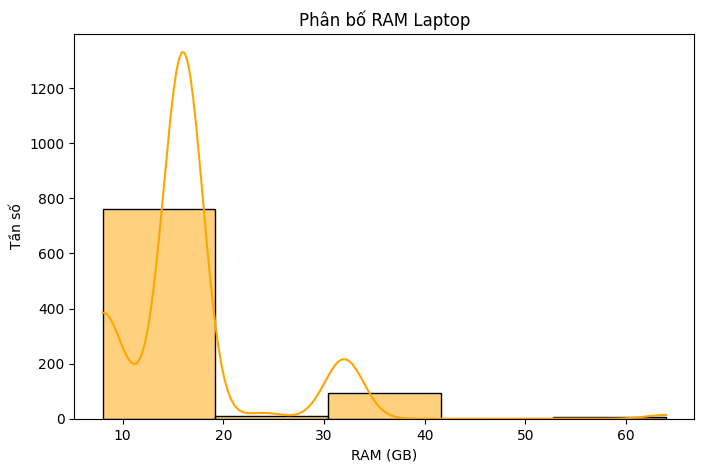

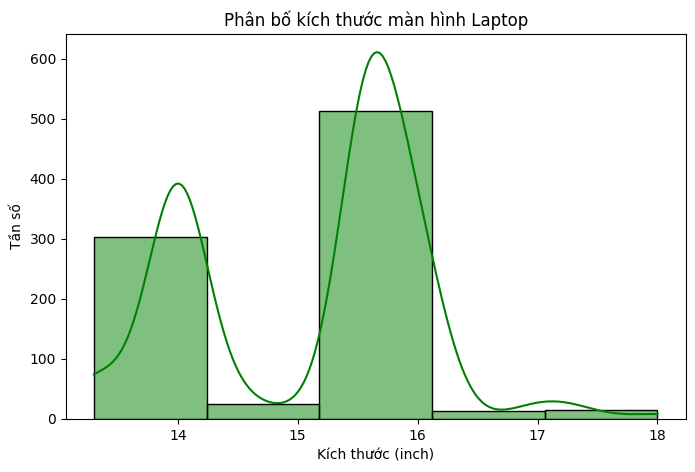

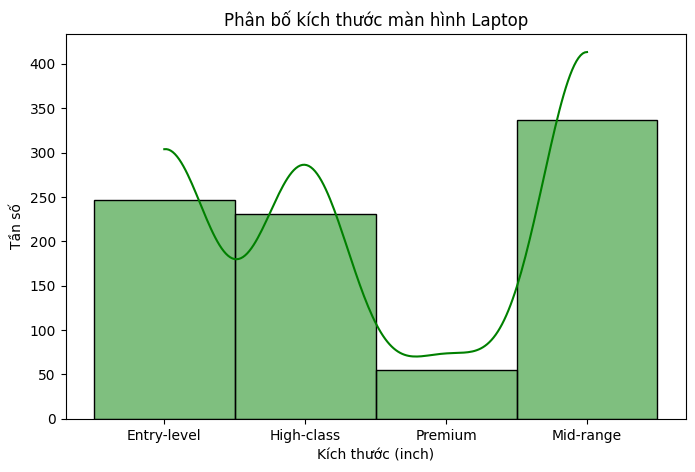

In [499]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



# Biểu đồ Histogram cho RAM
plt.figure(figsize=(8, 5))
sns.histplot(df['Ram'], bins=5, kde=True, color='orange')
plt.title('Phân bố RAM Laptop')
plt.xlabel('RAM (GB)')
plt.ylabel('Tần số')
plt.show()

# Biểu đồ Histogram cho Size
plt.figure(figsize=(8, 5))
sns.histplot(df['Size'], bins=5, kde=True, color='green')
plt.title('Phân bố kích thước màn hình Laptop')
plt.xlabel('Kích thước (inch)')
plt.ylabel('Tần số')
plt.show()
# Biểu đồ Histogram cho Size
plt.figure(figsize=(8, 5))
sns.histplot(df['CPU_type'], bins=5, kde=True, color='green')
plt.title('Phân bố kích thước màn hình Laptop')
plt.xlabel('Kích thước (inch)')
plt.ylabel('Tần số')
plt.show()


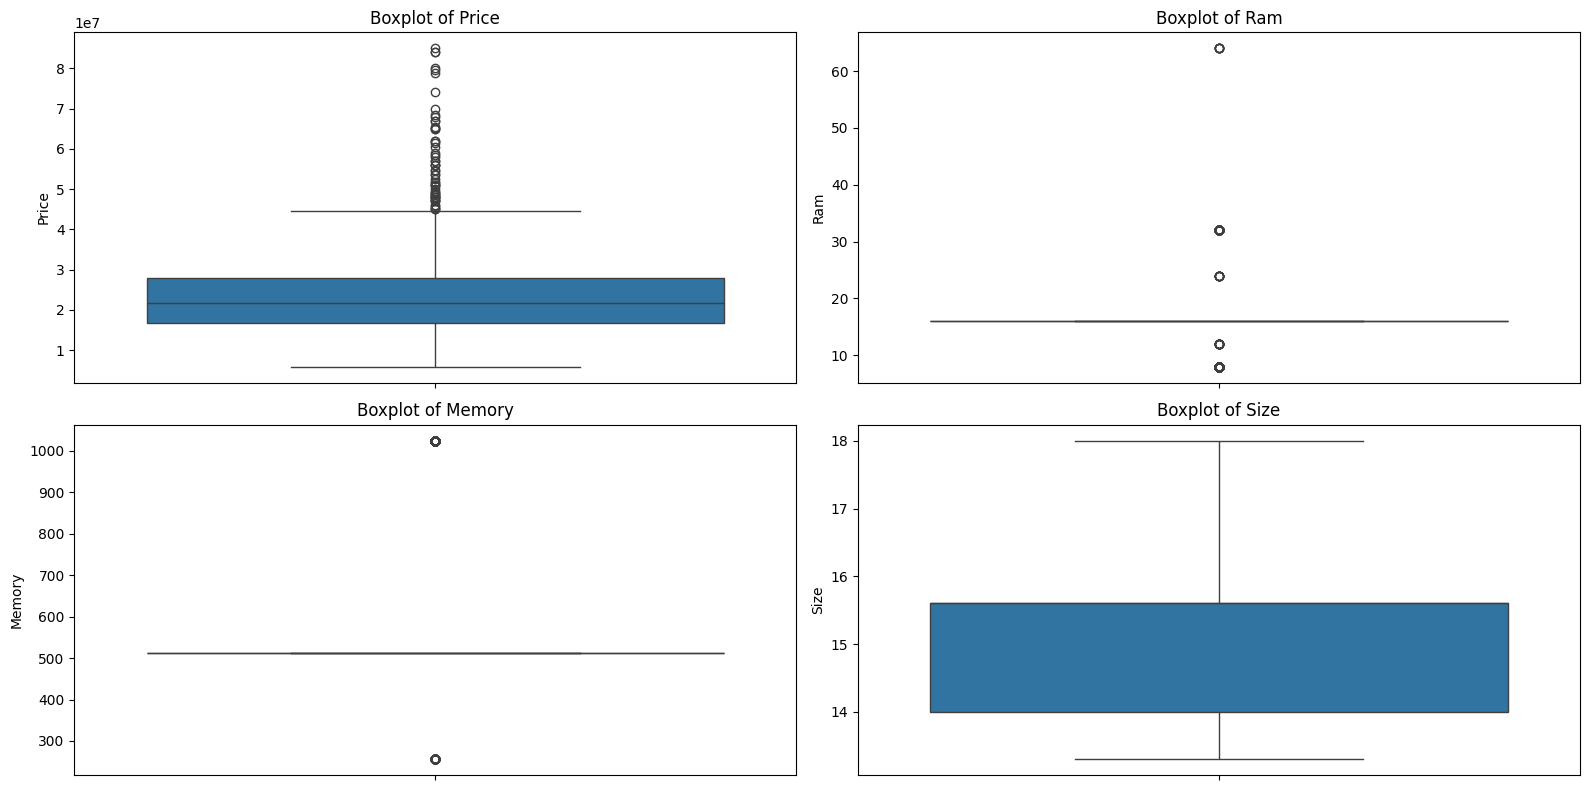

In [500]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt



# Loại bỏ các giá trị null trong cột số
numeric_columns = ["Price", "Ram", "Memory", "Size"]
df_clean = df.dropna(subset=numeric_columns)

# 1. Vẽ Boxplot cho các cột số
plt.figure(figsize=(16, 8))
for i, col in enumerate(numeric_columns, 1):
    plt.subplot(2, 2, i)  # Tạo 2x2 subplots
    sns.boxplot(data=df_clean, y=col)
    plt.title(f"Boxplot of {col}")
plt.tight_layout()
plt.show()

# # 2. Vẽ Scatter plot giữa cột 'Price' và các cột còn lại
# plt.figure(figsize=(16, 8))
# for i, col in enumerate(numeric_columns[1:], 1):  # Loại cột 'Price' khỏi vòng lặp
#     plt.subplot(2, 2, i)
#     sns.scatterplot(data=df_clean, x=col, y="Price", hue="GPU")
#     plt.title(f"Scatter Plot: {col} vs Price")
# plt.tight_layout()
# plt.show()


In [501]:
# # Hàm loại bỏ ngoại lai cho toàn bộ DataFrame
# def remove_outliers(df):
#     # Lọc các cột số
#     numeric_columns = df.select_dtypes(include=["number"]).columns
#     # Tạo một bản sao của DataFrame để giữ nguyên bản gốc
#     df_clean = df.copy()
    
#     # Áp dụng loại bỏ ngoại lai cho tất cả các cột số
#     for col in numeric_columns:
#         Q1 = df_clean[col].quantile(0.25)
#         Q3 = df_clean[col].quantile(0.75)
#         IQR = Q3 - Q1
#         lower_bound = Q1 - 1.5 * IQR
#         upper_bound = Q3 + 1.5 * IQR
#         df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]
    
#     return df_clean

# # Loại bỏ ngoại lai cho toàn bộ DataFrame
# df_clean = remove_outliers(df)

# # Vẽ lại Boxplot sau khi loại bỏ ngoại lai
# plt.figure(figsize=(16, 8))
# numeric_columns = df_clean.select_dtypes(include=["number"]).columns
# for i, col in enumerate(numeric_columns, 1):
#     plt.subplot(2, 2, i)
#     sns.boxplot(data=df_clean, y=col)
#     plt.title(f"Boxplot of {col} (Without Outliers)")
# plt.tight_layout()
# plt.show()


In [502]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Giả sử bạn đã có DataFrame df
# Tạo một bản sao của DataFrame để đảm bảo tính nguyên bản của dữ liệu
df_encoded = df.copy()
df_encoded=df_encoded.drop(columns=["Name","Link"])
# Xác định thứ tự giá trị mong muốn cho cột CPU_type
custom_cpu_order = ['Universal', 'Mid-range', 'High-class-workstation', 'High-class-graphics-gaming']

# Tạo một cột mới 'CPU_type' được mã hóa theo thứ tự custom_cpu_order
cpu_mapping = {cpu: idx for idx, cpu in enumerate(custom_cpu_order)}
df_encoded['GPU_type'] = df_encoded['CPU_type'].map(cpu_mapping)

# Label encoding cho các cột kiểu object
label_encoders = {}
categorical_columns = ['CPU_type', 'GPU_type']

for col in categorical_columns:
    label_encoder = LabelEncoder()
    df_encoded[col] = label_encoder.fit_transform(df_encoded[col])
    label_encoders[col] = label_encoder  # Lưu label encoder cho việc sử dụng sau này (nếu cần)

# Chuẩn hóa các cột số (Price, Ram, Memory, Size)
scaler = StandardScaler()
numerical_columns = ['Price', 'Ram', 'Memory', 'Size']
df_encoded[numerical_columns] = scaler.fit_transform(df_encoded[numerical_columns])

# Hiển thị kết quả
df_encoded


,Price,Ram,Memory,Size,GPU_type,CPU_type
0,-1.158152,-1.137061,-1.468928,-1.865732,1,0
1,-1.158152,-1.137061,-1.468928,-1.865732,1,0
2,-1.073847,-0.072292,-1.468928,-1.865732,1,0
3,-1.124430,-1.137061,-1.468928,-1.865732,1,0
4,-0.955820,-0.072292,-1.468928,-1.865732,1,0
...,...,...,...,...,...,...
959,0.021270,-0.072292,-0.314770,-1.142804,0,2
960,-0.138908,-0.072292,-0.314770,0.509603,0,2
962,1.749516,-1.137061,1.993544,-1.142804,1,1
964,-0.189491,-0.072292,-0.314770,-1.142804,0,2


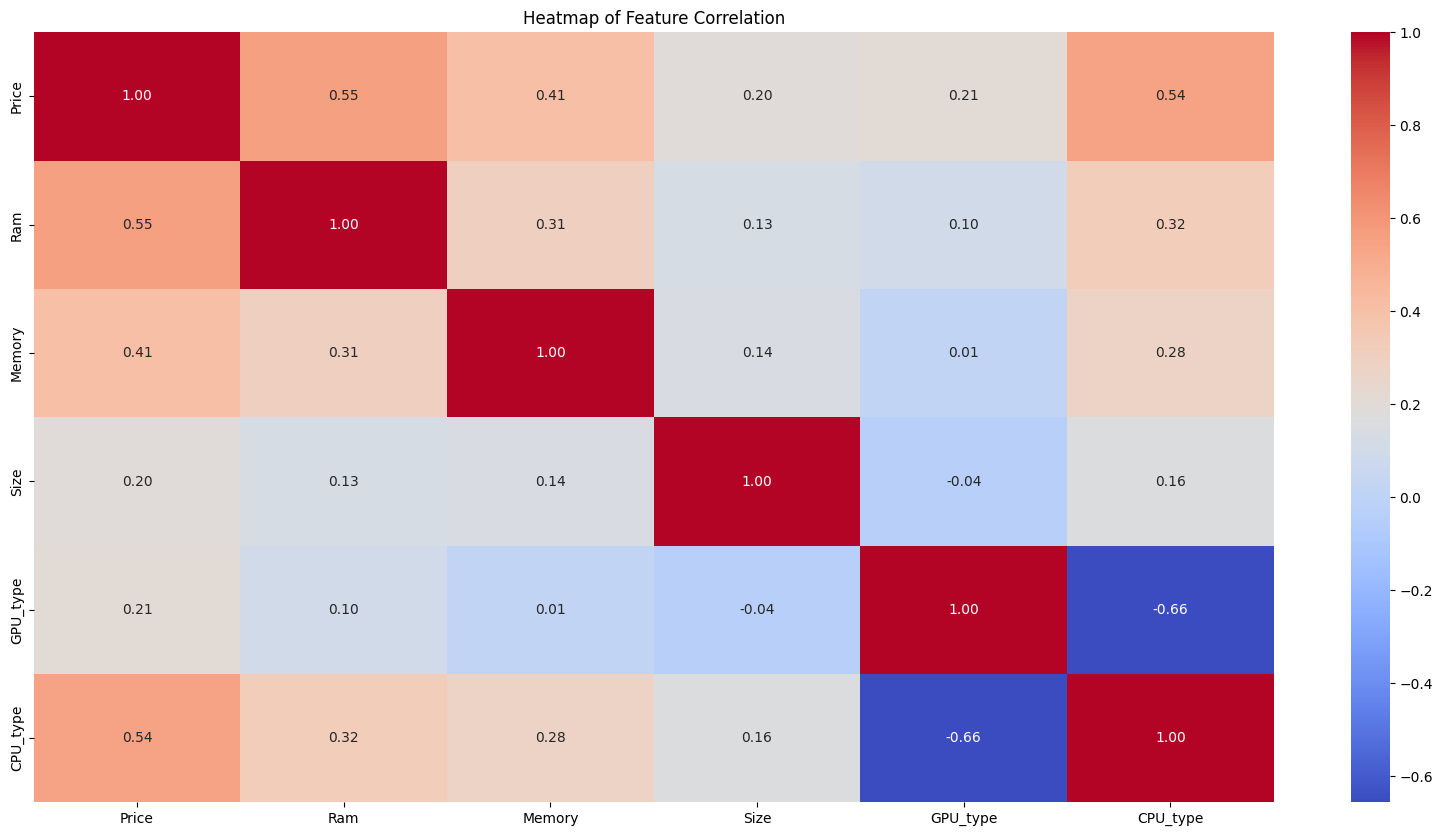

In [504]:
# Tính ma trận tương quan
correlation_matrix = df_encoded.corr()

# Vẽ heatmap
plt.figure(figsize=(20, 10))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Heatmap of Feature Correlation")
plt.show()

In [430]:
print(sorted(df['Ram'].unique().tolist()))
print(sorted(df['Memory'].unique().tolist()))
print(sorted(df['Size'].unique().tolist()))
print(sorted(df['GPU_type'].unique().tolist()))
print(sorted(df['CPU_type'].unique().tolist()))

[8.0, 12.0, 16.0, 24.0, 32.0, 64.0]
[256.0, 512.0, 1024.0]
[13.3, 13.4, 14.0, 14.5, 15.0, 15.6, 16.0, 17.0, 17.3, 18.0]
['High-class-graphics-gaming', 'High-class-workstation', 'Mid-range', 'Universal']
['Entry-level', 'High-class', 'Mid-range', 'Premium']


# Model

In [155]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score,mean_absolute_error
import joblib
from sklearn.base import BaseEstimator, TransformerMixin

In [156]:
df=df.dropna()
df

,Name,Price,Ram,Memory,Size,Link,GPU_type,CPU_type
0,Dell XPS 13 9360 | Core i7-8550U | Ram 8GB | S...,10500000.0,8.0,256.0,13.3,https://laptoptcc.com/dell-xps-13-9360-i5-7200...,Universal,Entry-level
1,Dell XPS 13 9360 |Core i7- 7500U | Ram 8GB | S...,10500000.0,8.0,256.0,13.3,https://laptoptcc.com/dell-xps-13-9360-i5-7200...,Universal,Entry-level
2,Laptop Cũ Dell XPS 13 9370 | Core i7 – 8550U| ...,11500000.0,16.0,256.0,13.3,https://laptoptcc.com/laptop-cu-dell-xps-13-93...,Universal,Entry-level
3,Dell XPS 13 9380 Core I5*8265U/ RAM 8GB/ SSD 2...,10900000.0,8.0,256.0,13.3,https://laptoptcc.com/dell-xps-13-9380-i7-8565...,Universal,Entry-level
4,Dell XPS 13 9380 Core i7- 8565U/ RAM 16GB/ SSD...,12900000.0,16.0,256.0,13.3,https://laptoptcc.com/dell-xps-13-9380-i7-8565...,Universal,Entry-level
...,...,...,...,...,...,...,...,...
959,Laptop HP EliteBook 640 G10 873G3PA (Intel Cor...,24490000.0,16.0,512.0,14.0,https://www.anphatpc.com.vn/laptop-hp-eliteboo...,Mid-range,Mid-range
960,Laptop HP 15-fd0083TU 8D736PA (Intel Core i7-1...,22590000.0,16.0,512.0,15.6,https://www.anphatpc.com.vn/laptop-hp-15-fd008...,Mid-range,Mid-range
962,Laptop ASUS TUF Gaming A14 FA401WV-RG062WS (AM...,44990000.0,8.0,1024.0,14.0,https://www.anphatpc.com.vn/laptop-asus-tuf-ga...,High-class-workstation,High-class
964,Laptop HP 14s-ep0110TU 8C5K9PA (Intel Core i7-...,21990000.0,16.0,512.0,14.0,https://www.anphatpc.com.vn/laptop-hp-14s-ep01...,Mid-range,Mid-range


### Seperating the Columns:

In [157]:
cpu_values = sorted(df['CPU_type'].unique().tolist())
cpu_values

['Entry-level', 'High-class', 'Mid-range', 'Premium']

Selecting the Numerical and Categorical Columns.

In [158]:
# Define the columns
categorical_columns = df.drop(columns=["Name","Link"]).select_dtypes(include=['object']).columns.tolist()
numerical_columns = df.drop(columns=["Name","Link"]).select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_columns.remove('Price')  # Exclude the target column from numerical columns


### Scaling and Encoding:

In [159]:
# Tạo transformer tùy chỉnh sử dụng LabelEncoder
class LabelEncoderTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.encoders = {}

    def fit(self, X, y=None):
        for col in X.columns:
            le = LabelEncoder()
            le.fit(X[col])
            self.encoders[col] = le
        return self

    def transform(self, X):
        X_transformed = X.copy()
        for col in X.columns:
            X_transformed[col] = self.encoders[col].transform(X[col])
        return X_transformed

    def inverse_transform(self, X):
        X_inverse = X.copy()
        for col in X.columns:
            X_inverse[col] = self.encoders[col].inverse_transform(X[col])
        return X_inverse

In [160]:

# Create transformers for numerical and categorical features
numerical_transformer = StandardScaler()
categorical_transformer = LabelEncoderTransformer()

# Combine transformers into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_columns),
        ('cat', categorical_transformer, categorical_columns)
    ])


## Splitting the Dataset:

In [161]:
# Create and fit the preprocessing pipeline
X = df.drop(columns=[ 'Price']) 
y = df['Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,shuffle=True)

preprocessor.fit(X_train)

# Save the preprocessor
joblib.dump(preprocessor, 'preprocessor.pkl')


['preprocessor.pkl']

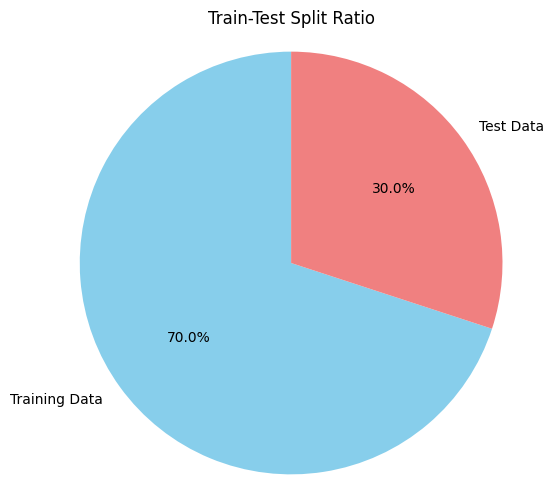

In [162]:
import matplotlib.pyplot as plt

# Tính tỷ lệ phần trăm của tập huấn luyện và tập kiểm tra
train_size = len(X_train)
test_size = len(X_test)
total_size = train_size + test_size

train_percent = (train_size / total_size) * 100
test_percent = (test_size / total_size) * 100

# Dữ liệu và nhãn cho biểu đồ
sizes = [train_percent, test_percent]
labels = ['Training Data', 'Test Data']

# Vẽ biểu đồ
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=['skyblue', 'lightcoral'])
plt.title('Train-Test Split Ratio')
plt.axis('equal')  # Đảm bảo biểu đồ là hình tròn
plt.show()

## Defining the Models and Training:

In [163]:
import joblib
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split

# Định nghĩa các model ban đầu
models = {
    "Decision Tree": DecisionTreeRegressor(max_depth=10, random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, max_depth=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42),
    # "LightGBM": LGBMRegressor(n_estimators=100, learning_rate=0.1, force_row_wise=True, random_state=42)
}

best_model = None
best_score = float('-inf')  # Giá trị R² khởi tạo
best_model_name = ""


# Biến lưu kết quả
results = {"Model": [], "R²": [], "MAE": [], "RMSE": []}

# Vòng lặp huấn luyện và đánh giá
while best_score <= 0.95:  # Tiếp tục cho đến khi R² > 0.95
    # Dữ liệu (giả định `df` đã được chuẩn bị)
    X = df.drop(columns=['Price'])  # Các đặc trưng
    y = df['Price']  # Biến mục tiêu
    # Chia dữ liệu thành tập huấn luyện và kiểm tra
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

   
    for name, model in models.items():
        # Huấn luyện mô hình
        model.fit(preprocessor.transform(X_train), y_train)
        
        # Dự đoán
        y_pred = model.predict(preprocessor.transform(X_test))
        
        # Tính toán các độ đo
        r2 = r2_score(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        
        # Lưu kết quả
        results["Model"].append(name)
        results["R²"].append(r2)
        results["MAE"].append(mae)
        results["RMSE"].append(rmse)
        
        # In kết quả
        print(f"{name} - R² score: {r2:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}")
        
        # Lưu mô hình
        joblib.dump(model, f"{name.replace(' ', '_')}.pkl")
        
        # Lưu lại mô hình tốt nhất
        if r2 > best_score:
            best_score = r2
            best_model = model
            best_model_name = name
    
    # Kiểm tra điều kiện dừng
    if best_score > 0.95:
        break


Decision Tree - R² score: 0.8350, MAE: 2902459.7498, RMSE: 5049565.0010
Random Forest - R² score: 0.8721, MAE: 2761229.2443, RMSE: 4445897.0127
XGBoost - R² score: 0.8595, MAE: 2853524.7011, RMSE: 4659500.2888
Decision Tree - R² score: 0.9071, MAE: 2524561.4822, RMSE: 4074598.4657
Random Forest - R² score: 0.9205, MAE: 2410074.8143, RMSE: 3768058.6094
XGBoost - R² score: 0.9098, MAE: 2491541.6437, RMSE: 4013969.4337
Decision Tree - R² score: 0.9232, MAE: 2049342.6312, RMSE: 3178237.6287
Random Forest - R² score: 0.9370, MAE: 1976007.0300, RMSE: 2878625.6333
XGBoost - R² score: 0.9467, MAE: 1955899.8448, RMSE: 2648736.8819
Decision Tree - R² score: 0.8570, MAE: 2678587.8904, RMSE: 4658808.8597
Random Forest - R² score: 0.8842, MAE: 2571753.5231, RMSE: 4192168.2371
XGBoost - R² score: 0.8598, MAE: 2657152.4885, RMSE: 4611884.7291
Decision Tree - R² score: 0.8900, MAE: 2499836.9739, RMSE: 3973743.2147
Random Forest - R² score: 0.8983, MAE: 2499823.6073, RMSE: 3820942.9649
XGBoost - R² sco

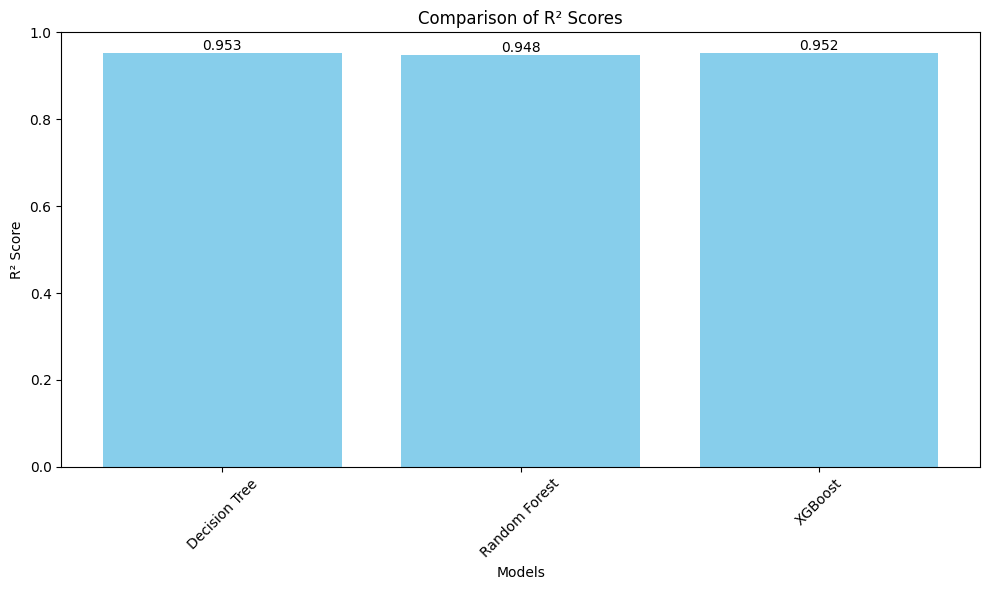

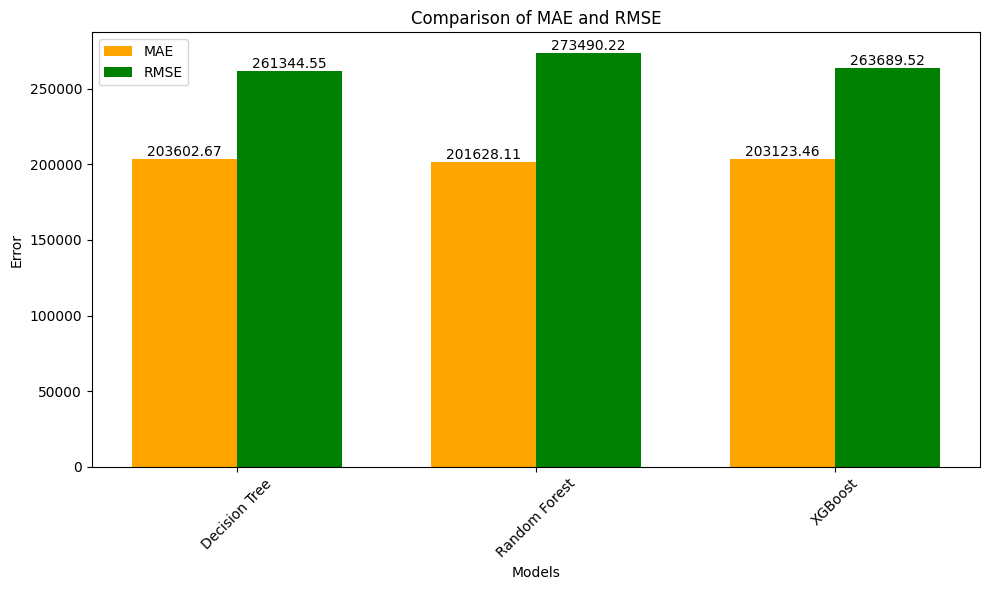

In [164]:
# ---------------------------------
# Đánh giá các mô hình đã lưu
# ---------------------------------
loaded_results = {"Model": [], "R²": [], "MAE": [], "RMSE": []}

for name in models.keys():
    # Load mô hình
    model = joblib.load(f"{name.replace(' ', '_')}.pkl")
    
    # Dự đoán
    y_pred = model.predict(preprocessor.transform(X_test))
    
    # Tính toán các độ đo
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)/10
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))/10
    
    # Lưu kết quả
    loaded_results["Model"].append(name)
    loaded_results["R²"].append(r2)
    loaded_results["MAE"].append(mae)
    loaded_results["RMSE"].append(rmse)

# ---------------------------------
# Vẽ biểu đồ
# ---------------------------------

# Biểu đồ so sánh R²
plt.figure(figsize=(10, 6))
bars_r2 = plt.bar(loaded_results["Model"], loaded_results["R²"], color='skyblue')
plt.title("Comparison of R² Scores")
plt.ylabel("R² Score")
plt.xlabel("Models")
plt.xticks(rotation=45)

# Hiển thị giá trị R² trên các thanh
for bar in bars_r2:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 3), ha='center', va='bottom')

plt.tight_layout()
plt.savefig("comparison_r2.png")
plt.show()

# Biểu đồ so sánh MAE và RMSE
x = np.arange(len(loaded_results["Model"]))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, loaded_results["MAE"], width, label='MAE', color='orange')
rects2 = ax.bar(x + width/2, loaded_results["RMSE"], width, label='RMSE', color='green')

ax.set_title("Comparison of MAE and RMSE")
ax.set_xticks(x)
ax.set_xticklabels(loaded_results["Model"], rotation=45)
ax.set_ylabel("Error")
ax.set_xlabel("Models")
ax.legend()

# Hiển thị giá trị MAE và RMSE trên các thanh
for rect in rects1:
    yval = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

for rect in rects2:
    yval = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

fig.tight_layout()
plt.savefig("comparison_mae_rmse.png")
plt.show()


In [165]:
# Lưu lại mô hình tốt nhất
joblib.dump(best_model, 'best_model.pkl')

print(f"Best model: {best_model_name} with R² score: {best_score:.4f}")

Best model: Decision Tree with R² score: 0.9527


## Hyperparameter Tuning:

In [166]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import joblib
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# Định nghĩa models và hyperparameter grid
models = {
    "Decision Tree": (DecisionTreeRegressor(random_state=42), {
        'max_depth': [5, 10, 15, 20, None],
        'min_samples_split': [2, 5, 10]
    }),
    "Random Forest": (RandomForestRegressor(random_state=42), {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30]
    }),
    "XGBoost": (XGBRegressor(random_state=42), {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 4, 5, 6],
        'learning_rate': [0.01, 0.1, 0.2]
    }),
}

# Khởi tạo giá trị ban đầu
best_model = None
best_score = float('-inf')  # Giá trị R² khởi tạo
best_model_name = ""

# Khởi tạo danh sách lưu kết quả
results = {"Model": [], "R2": [], "RMSE": [], "MAE": []}

# Giả định dữ liệu đã tiền xử lý
X = df.drop(columns=['Price'])
y = df['Price']


while best_score <= 0.94:
    for name, (model, param_grid) in models.items():
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2 , shuffle=True)
        print(f"Tuning hyperparameters for {name}...")

        # Tuning hyperparameters với RandomizedSearchCV
        search = RandomizedSearchCV(
            model, param_grid, n_iter=10, cv=5, scoring='r2', random_state=42, n_jobs=-1
        )
        search.fit(preprocessor.transform(X_train), y_train)

        # Mô hình với bộ tham số tốt nhất
        best_model_for_name = search.best_estimator_

        # Dự đoán
        y_pred = best_model_for_name.predict(preprocessor.transform(X_test))

        # Tính toán các độ đo
        r2 = r2_score(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))

        # Lưu kết quả vào danh sách
        results["Model"].append(name)
        results["R2"].append(r2)
        results["RMSE"].append(rmse)
        results["MAE"].append(mae)

        # In kết quả
        print(f"{name} - R² score: {r2:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}")

        # Lưu lại mô hình tốt nhất dựa trên R²
        if r2 > best_score:
            best_score = r2
            best_model = best_model_for_name
            best_model_name = name
        # Lưu model với tên chứa tên model và siêu tham số
        hyperparams = search.best_params_
        hyperparams_str = "_".join([f"{key}={value}" for key, value in hyperparams.items()])
        model_filename = f"{name}_hyperparams.pkl"
        joblib.dump(best_model_for_name, model_filename)
        print(f"Model saved: {model_filename}")
    # Kiểm tra nếu đạt điều kiện
    if best_score > 0.94:
        print(f"Stopping training as R² > 0.94 achieved with {best_model_name}")
        break
    else:
        print("R² chưa đạt > 0.94, tiếp tục huấn luyện lại...")






Tuning hyperparameters for Decision Tree...
Decision Tree - R² score: 0.8246, RMSE: 4751762.5154, MAE: 2915547.2740
Model saved: Decision Tree_hyperparams.pkl
Tuning hyperparameters for Random Forest...
Random Forest - R² score: 0.9008, RMSE: 3385109.4719, MAE: 2344894.4017
Model saved: Random Forest_hyperparams.pkl
Tuning hyperparameters for XGBoost...
XGBoost - R² score: 0.9130, RMSE: 3670080.2425, MAE: 2463296.4943
Model saved: XGBoost_hyperparams.pkl
R² chưa đạt > 0.94, tiếp tục huấn luyện lại...
Tuning hyperparameters for Decision Tree...
Decision Tree - R² score: 0.8931, RMSE: 3845154.9684, MAE: 2510691.8028
Model saved: Decision Tree_hyperparams.pkl
Tuning hyperparameters for Random Forest...
Random Forest - R² score: 0.9350, RMSE: 3366623.1024, MAE: 2225948.4981
Model saved: Random Forest_hyperparams.pkl
Tuning hyperparameters for XGBoost...
XGBoost - R² score: 0.8792, RMSE: 3963596.0416, MAE: 2558045.1782
Model saved: XGBoost_hyperparams.pkl
R² chưa đạt > 0.94, tiếp tục huấn l

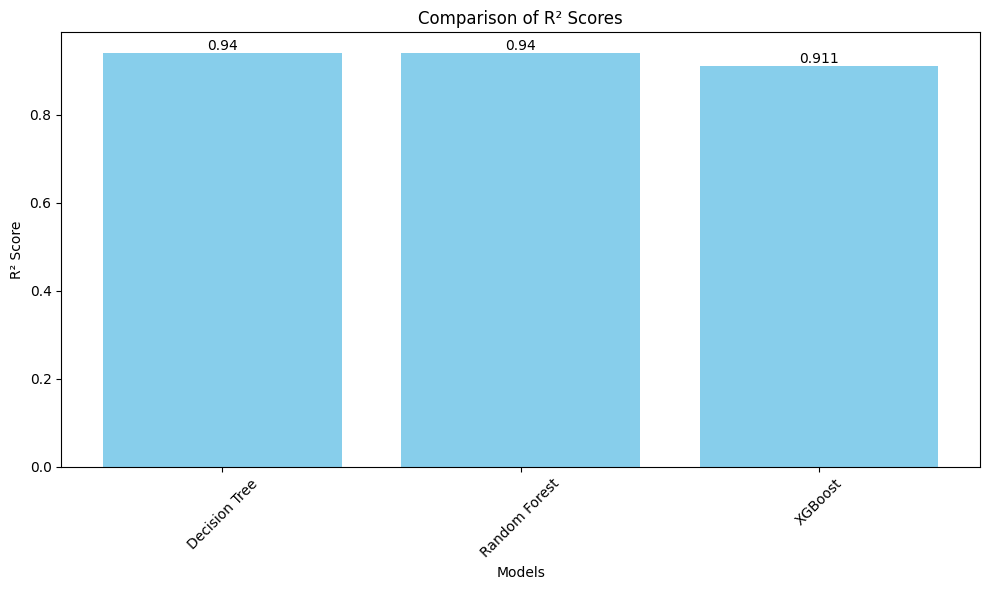

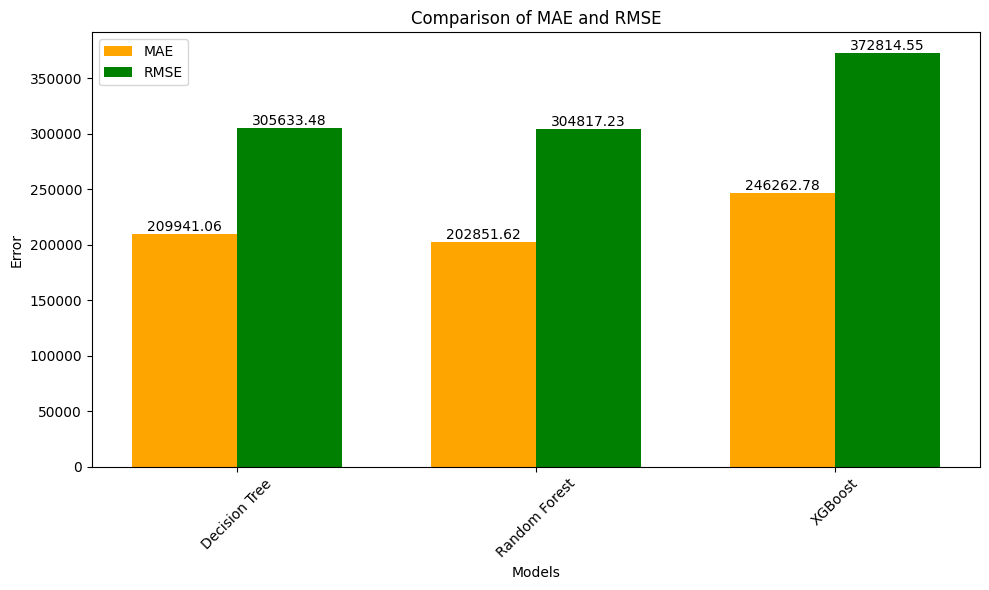

In [167]:
# ---------------------------------
# Đánh giá các mô hình đã lưu
# ---------------------------------
loaded_results = {"Model": [], "R²": [], "MAE": [], "RMSE": []}

for name in models.keys():
    # Load mô hình
    model = joblib.load(f"{name}_hyperparams.pkl")
    
    # Dự đoán
    y_pred = model.predict(preprocessor.transform(X_test))
    
    # Tính toán các độ đo
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)/10
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))/10
    
    # Lưu kết quả
    loaded_results["Model"].append(name)
    loaded_results["R²"].append(r2)
    loaded_results["MAE"].append(mae)
    loaded_results["RMSE"].append(rmse)

# ---------------------------------
# Vẽ biểu đồ
# ---------------------------------

# Biểu đồ so sánh R²
plt.figure(figsize=(10, 6))
bars_r2 = plt.bar(loaded_results["Model"], loaded_results["R²"], color='skyblue')
plt.title("Comparison of R² Scores")
plt.ylabel("R² Score")
plt.xlabel("Models")
plt.xticks(rotation=45)

# Hiển thị giá trị R² trên các thanh
for bar in bars_r2:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 3), ha='center', va='bottom')

plt.tight_layout()
plt.savefig("comparison_r2.png")
plt.show()

# Biểu đồ so sánh MAE và RMSE
x = np.arange(len(loaded_results["Model"]))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, loaded_results["MAE"], width, label='MAE', color='orange')
rects2 = ax.bar(x + width/2, loaded_results["RMSE"], width, label='RMSE', color='green')

ax.set_title("Comparison of MAE and RMSE")
ax.set_xticks(x)
ax.set_xticklabels(loaded_results["Model"], rotation=45)
ax.set_ylabel("Error")
ax.set_xlabel("Models")
ax.legend()

# Hiển thị giá trị MAE và RMSE trên các thanh
for rect in rects1:
    yval = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

for rect in rects2:
    yval = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

fig.tight_layout()
plt.savefig("comparison_mae_rmse.png")
plt.show()


In [168]:
# Load lại mô hình từ file cố định
loaded_best_model = joblib.load("hypertuned_best_model.pkl")


In [169]:
# # Lưu lại mô hình tốt nhất
# joblib.dump(best_model, 'hypertuned_best_model.pkl')

# print(f"Best model: {best_model_name} with R² score: {best_score:.4f}")

In [170]:
import joblib
import numpy as np
import pandas as pd

# Load the preprocessor and model
preprocessor = joblib.load('preprocessor.pkl')
model = joblib.load('best_model.pkl')  # Hoặc 'best_model.pkl' nếu không dùng hyperparameter tuning

# Định nghĩa một hàm để thực hiện dự đoán
def predict(features):
    """
    Thực hiện dự đoán giá laptop từ đặc trưng đầu vào.
    
    Parameters:
        features (dict): Từ điển chứa các đặc trưng cần dự đoán.
        
    Returns:
        float: Dự đoán giá.
    """
    # Chuyển dữ liệu đầu vào thành DataFrame để xử lý
    input_data = pd.DataFrame([features])  # Biến đổi thành một hàng duy nhất
    
    # Áp dụng preprocessing
    processed_data = preprocessor.transform(input_data)
    
    # Dự đoán giá
    prediction = model.predict(processed_data)
    
    return prediction[0]

# Ví dụ về đặc trưng đầu vào
input_features = {
      # Cột dạng chuỗi
    'Ram': 16,             # Cột số
    'Memory': 256,        # Cột số
    'CPU_type': 'High-class',     # Cột dạng chuỗi
    'GPU_type': 'Universal',   # Cột dạng chuỗi
    'Size': 13.3  ,   # Cột số
    # Thêm các đặc trưng khác nếu cần
}

# Thực hiện dự đoán
predicted_price = predict(input_features)
print(f"Dự đoán giá laptop: {predicted_price:.2f} VNĐ")


Dự đoán giá laptop: 12700000.00 VNĐ


<h1><b><p style="background-color:#09375b;font-family:camtasia;font-size:110%;color:white;text-align:center;border-radius:15px 50px; padding:7px; border:solid 2px #09375b; box-shadow: 10px 10px 10px #042b4c">THE END</p></b></h1>